<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-the-Bayesian-Hyperparameter-Optimisation-Algorithm" data-toc-modified-id="Import-the-Bayesian-Hyperparameter-Optimisation-Algorithm-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import the Bayesian Hyperparameter Optimisation Algorithm</a></span></li><li><span><a href="#Example-Use-Case" data-toc-modified-id="Example-Use-Case-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example Use Case</a></span><ul class="toc-item"><li><span><a href="#Generate-some-training-data" data-toc-modified-id="Generate-some-training-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate some training data</a></span></li><li><span><a href="#Run-the-Optimisation---continuous-hyperparameters" data-toc-modified-id="Run-the-Optimisation---continuous-hyperparameters-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Run the Optimisation - continuous hyperparameters</a></span></li><li><span><a href="#Plot-the-Samples" data-toc-modified-id="Plot-the-Samples-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Plot the Samples</a></span></li><li><span><a href="#Plot-Convergence-of-the-Model-Score" data-toc-modified-id="Plot-Convergence-of-the-Model-Score-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Plot Convergence of the Model Score</a></span></li><li><span><a href="#Check-performance-of-best-parameter-values" data-toc-modified-id="Check-performance-of-best-parameter-values-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Check performance of best parameter values</a></span></li></ul></li><li><span><a href="#Run-the-Optimisation---Discrete-hyperparameters" data-toc-modified-id="Run-the-Optimisation---Discrete-hyperparameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run the Optimisation - Discrete hyperparameters</a></span></li><li><span><a href="#Setting-Number-of-Iterations" data-toc-modified-id="Setting-Number-of-Iterations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Setting Number of Iterations</a></span></li><li><span><a href="#Advanced-User-defined-Inputs" data-toc-modified-id="Advanced-User-defined-Inputs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Advanced User-defined Inputs</a></span><ul class="toc-item"><li><span><a href="#Providing-your-own-scoring-function" data-toc-modified-id="Providing-your-own-scoring-function-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Providing your own scoring function</a></span><ul class="toc-item"><li><span><a href="#Example-1" data-toc-modified-id="Example-1-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Example 1</a></span></li><li><span><a href="#Example-2" data-toc-modified-id="Example-2-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Example 2</a></span></li></ul></li><li><span><a href="#Convergence-Diagnostics" data-toc-modified-id="Convergence-Diagnostics-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Convergence Diagnostics</a></span></li></ul></li><li><span><a href="#Try-unsupervised-learning" data-toc-modified-id="Try-unsupervised-learning-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Try unsupervised learning</a></span></li><li><span><a href="#Using-random_search-solver-for-discrete-valued-hyperparameters" data-toc-modified-id="Using-random_search-solver-for-discrete-valued-hyperparameters-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Using random_search solver for discrete valued hyperparameters</a></span></li><li><span><a href="#Nested-CV-for-Model-Selection" data-toc-modified-id="Nested-CV-for-Model-Selection-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Nested CV for Model Selection</a></span></li><li><span><a href="#Ignore-this-for-now..." data-toc-modified-id="Ignore-this-for-now...-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Ignore this for now...</a></span></li></ul></div>

In [1]:
# That is setting up the autoreload mode to automatically 
# reload your imports when you edit a file
%load_ext autoreload
%autoreload 2

# Import the Bayesian Hyperparameter Optimisation Algorithm

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
from bayesian_hyperparameter_optimisation_3 import BayesianOptimisation
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, RBF
import matplotlib.pyplot as plt

# Example Use Case
## Generate some training data

In [3]:
def generate_noisy_data_from_bivariate_gaussian(z):
    
    "Define a simple 2-D gaussian to generate noisy data"
    
    x = z[:,0].reshape(-1,1)
    y = z[:,1].reshape(-1,1)
    return 1-np.exp(-((x-5)/10)**2)*np.exp(-((y-10)/10)**2)+0.1*np.random.uniform(size=(1000,1))#,loc=0,scale=1)

def generate_noisy_data_from_bivariate_gaussian_nd(z, mu, sig):
    
    "Define a simple 3-D gaussian to generate noisy data"
    
    G = np.ones((z.shape[0],1))
    for i in range(z.shape[1]):
        G = G*np.exp(-((z[:,i]-mu[i])/sig[i])**2).reshape(-1,1)
    
    return 1-G+0.1*np.random.uniform(size=(1000,1))


# --- Generate our training data

# Generate random x data from 0 to 15
X_train = 15*np.random.uniform(size=(1000,2))
# Generate noisy data from a 2D gaussian defined above
y_train = generate_noisy_data_from_bivariate_gaussian(X_train)
y_train = y_train.ravel()

X_test = 15*np.random.uniform(size=(1000,2))
y_test = generate_noisy_data_from_bivariate_gaussian(X_test)
y_test = y_test.ravel()

## Run the Optimisation - continuous hyperparameters

In [3]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound, upper_bound] for continuous
hps = {
    'min_samples_leaf': [0.1, 0.5]
}

# --- Run the Bayesian Optimisation Code
BOout = BayesianOptimisation(
    hps = hps,
    MLmodel = RandomForestRegressor(random_state=42),
    y_train = y_train,
    X_train = X_train
)
BOout.optimise()

INFO:root:Performing initial 2 samples
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'min_samples_leaf': 0.3577469389763034} score: -0.011011101155630332
{'min_samples_leaf': 0.31530131200741673} score: 0.29011816964396675


INFO:root:Will perform 10 iterations


Iteration: 0
{'min_samples_leaf': 0.26924539187426244} score: 0.39504057031373935
current accuracy: 0.39504057031373935
best accuracy: 0.39504057031373935
Iteration: 1
{'min_samples_leaf': 0.1} score: 0.8160356361905189
current accuracy: 0.8160356361905189
best accuracy: 0.8160356361905189
Iteration: 2
{'min_samples_leaf': 0.1} score: 0.8160356361905189
current accuracy: 0.8160356361905189
best accuracy: 0.8160356361905189
Iteration: 3
{'min_samples_leaf': 0.1} score: 0.8160356361905189
current accuracy: 0.8160356361905189
best accuracy: 0.8160356361905189
Iteration: 4
{'min_samples_leaf': 0.10000000000000002} score: 0.8080765883394416
current accuracy: 0.8080765883394416
best accuracy: 0.8160356361905189
Iteration: 5
{'min_samples_leaf': 0.1} score: 0.8160356361905189
current accuracy: 0.8160356361905189
best accuracy: 0.8160356361905189
Iteration: 6
{'min_samples_leaf': 0.1} score: 0.8160356361905189
current accuracy: 0.8160356361905189
best accuracy: 0.8160356361905189
Iteration: 7


INFO:root:Best result 0.8160356361905189: Params: {'min_samples_leaf': 0.1}


## Plot the Samples

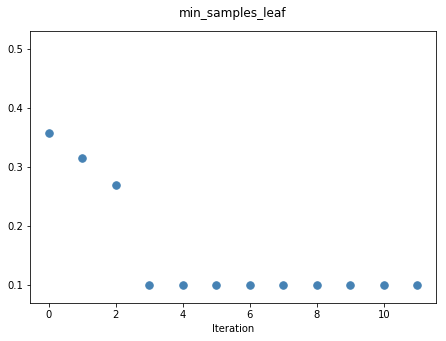

In [4]:
# --- Track the results with each iteration
BOout.hyperparameter_convergence_plots()

## Plot Convergence of the Model Score

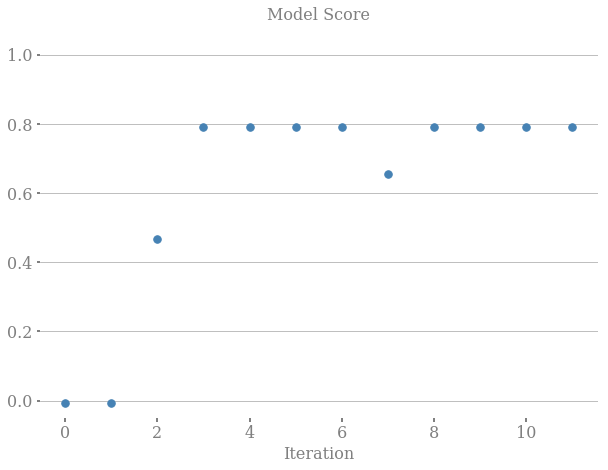

In [228]:
BOout.model_accuracy_convergence_plot()

## Check performance of best parameter values

In [229]:
best_params = BOout.best_params_vals
print(best_params)

{'min_samples_leaf': 0.1}


In [230]:
RFr = RandomForestRegressor(
    **best_params,
    random_state=42
)#.fit(X_train,y_train)
np.mean(cross_val_score(RFr, X_train, y_train, cv=5))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

0.789783104351493

# Run the Optimisation - Discrete hyperparameters
The optimisatin of the acquisition function for continuous variables is a constrained optimisation algoroithm; this only works for continuous variables. If you're using discrete parameter values then you should set the parameter optim_rout to random_search to 'random_search'. This doesn't affect the Bayesian optimisation of the actual ML model hyperparameters. If you don't do this then it will automatically change it for you and raise a warning.

In [233]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound, upper_bound] for continuous
hps = {
    'n_estimators': range(10, 100),
    'min_samples_leaf': [0.001, 0.5]
}

# --- Run the Bayesian Optimisation Code
BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = RandomForestRegressor(random_state=42),
    y_train = y_train,
    X_train = X_train,
    optim_rout = 'random_search'
)
BOout.optimise()

INFO:root:Performing initial 4 samples


{'min_samples_leaf': 0.10906211028877257, 'n_estimators': 71} score: 0.7747527370739636
{'min_samples_leaf': 0.31745757584753714, 'n_estimators': 77} score: 0.18458644235920119
{'min_samples_leaf': 0.3173873861429869, 'n_estimators': 37} score: 0.16191792827539792
{'min_samples_leaf': 0.4720132778132007, 'n_estimators': 76} score: -0.0066004954013283434


INFO:root:Will perform 20 iterations


Iteration: 0
{'min_samples_leaf': 0.17250861154887184, 'n_estimators': 66} score: 0.7323926415960101
current accuracy: 0.7323926415960101
best accuracy: 0.7747527370739636
Iteration: 1
{'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 68} score: 0.9738522583578861
current accuracy: 0.9738522583578861
best accuracy: 0.9738522583578861
Iteration: 2
{'min_samples_leaf': 0.001, 'n_estimators': 84} score: 0.973886611125278
current accuracy: 0.973886611125278
best accuracy: 0.973886611125278
Iteration: 3
{'min_samples_leaf': 0.001, 'n_estimators': 91} score: 0.9739187582936107
current accuracy: 0.9739187582936107
best accuracy: 0.9739187582936107
Iteration: 4
{'min_samples_leaf': 0.0010000000000000286, 'n_estimators': 86} score: 0.9738715590001339
current accuracy: 0.9738715590001339
best accuracy: 0.9739187582936107
Iteration: 5
{'min_samples_leaf': 0.49999999999999994, 'n_estimators': 97} score: -0.0068093830363190385
current accuracy: -0.0068093830363190385
best accuracy: 0.9739

INFO:root:Best result 0.9739433134951782: Params: {'min_samples_leaf': 0.001, 'n_estimators': 92.0}


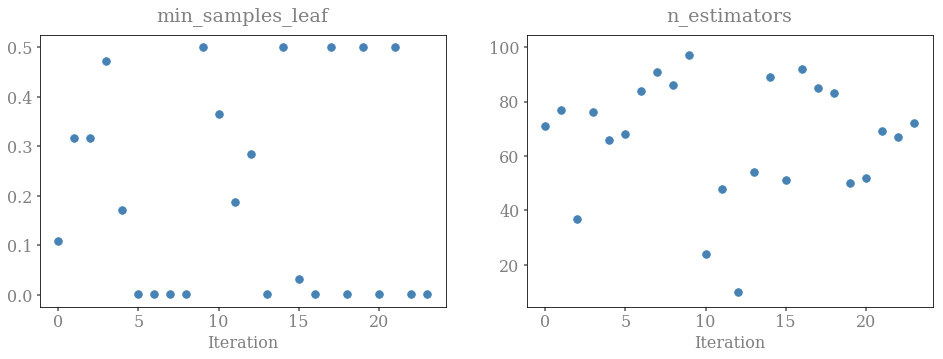

In [234]:
BOout.hyperparameter_convergence_plots()

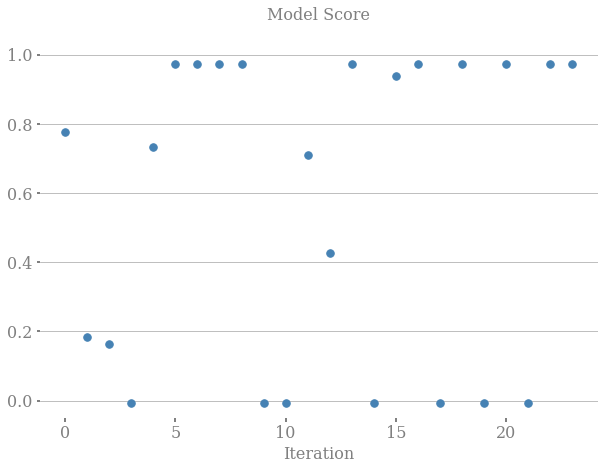

In [235]:
BOout.model_accuracy_convergence_plot()

# Setting Number of Iterations
We can change both the number of initial samples taken and the subsequent number of iterations. The initial samples are chosen using random search so don;t set this too high otherwise you'll hit an optimal value before needing the Bayesian part. Too low and the algorithm will take longer to converge but the benefit of Bayesian optimisation is that it will converge so ur on the side of lower.

There are 2 additional parameters we need to parse:
- NpI: number of initial samples
- Niter: number of subsequent iterations

Another consideration is that the algorithm that finds the optimum set of hyperparameters from the Gaussian process is dependent on the starting guess,  much like Newton-Raphson. In the case of random_search we also want to be able to set how many values we choose to sample. This can be set by the n_restarts parameter.
- n_restarts: number of random samples chosen for random search/number of starting points that we initiate the constrained optimisation algorithm from.

In [236]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound, upper_bound] for continuous
hps = {
    'n_estimators': range(10, 100),
    'min_samples_leaf': [0.001,0.1]
}

# --- Run the Bayesian Optimisation Code
BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = RandomForestRegressor(random_state=42),
    y_train = y_train,
    X_train = X_train,
    optim_rout = 'random_search',
    NpI = 8,
    Niter = 40,
    n_restarts = 100
)
BOout.optimise()

INFO:root:Performing initial 8 samples


{'min_samples_leaf': 0.014978739210724953, 'n_estimators': 95} score: 0.955062257209274
{'min_samples_leaf': 0.015096530185217203, 'n_estimators': 54} score: 0.9527734187725038
{'min_samples_leaf': 0.02078756012723387, 'n_estimators': 30} score: 0.9471640153244705
{'min_samples_leaf': 0.08098463726609452, 'n_estimators': 96} score: 0.8360359218639937
{'min_samples_leaf': 0.024281323405558213, 'n_estimators': 44} score: 0.9443670101775863
{'min_samples_leaf': 0.03442561632306178, 'n_estimators': 22} score: 0.9337126421578323
{'min_samples_leaf': 0.05893160679626489, 'n_estimators': 79} score: 0.9121350073854101
{'min_samples_leaf': 0.0579069082434558, 'n_estimators': 60} score: 0.9152658032939115


INFO:root:Will perform 40 iterations


Iteration: 0
{'min_samples_leaf': 0.03896099597872916, 'n_estimators': 51} score: 0.9301238018496158
current accuracy: 0.9301238018496158
best accuracy: 0.955062257209274
Iteration: 1
{'min_samples_leaf': 0.036084222393248204, 'n_estimators': 10} score: 0.9311676349445415
current accuracy: 0.9311676349445415
best accuracy: 0.955062257209274
Iteration: 2
{'min_samples_leaf': 0.003556970272600576, 'n_estimators': 10} score: 0.9719882306396516
current accuracy: 0.9719882306396516
best accuracy: 0.9719882306396516
Iteration: 3
{'min_samples_leaf': 0.028165823956771596, 'n_estimators': 10} score: 0.9399731923699474
current accuracy: 0.9399731923699474
best accuracy: 0.9719882306396516
Iteration: 4
{'min_samples_leaf': 0.08669054608074564, 'n_estimators': 10} score: 0.8230085894691509
current accuracy: 0.8230085894691509
best accuracy: 0.9719882306396516
Iteration: 5
{'min_samples_leaf': 0.02610692162494976, 'n_estimators': 99} score: 0.943528950226568
current accuracy: 0.943528950226568
bes

INFO:root:Best result 0.9733785462089808: Params: {'min_samples_leaf': 0.0028048697730878236, 'n_estimators': 97.0}


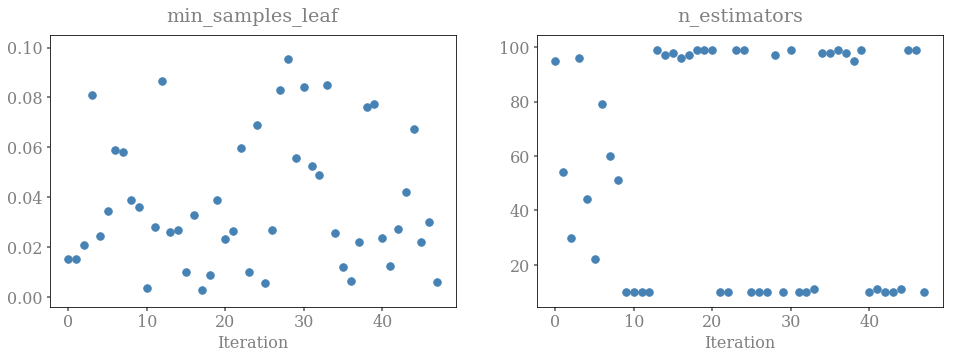

In [237]:
BOout.hyperparameter_convergence_plots()

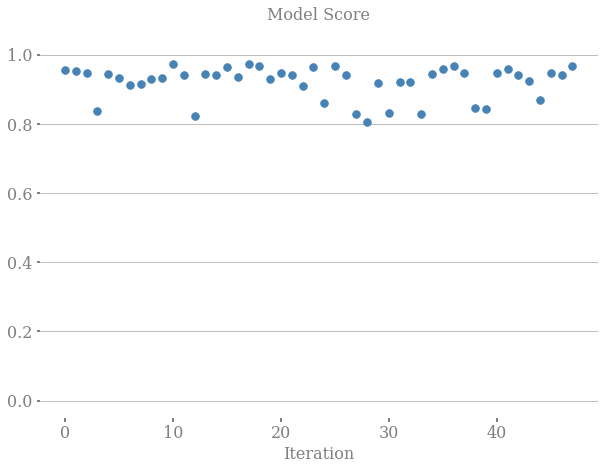

In [238]:
BOout.model_accuracy_convergence_plot()

# Advanced User-defined Inputs
## Providing your own scoring function

### Example 1

In [239]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators': range(1, 100),
    'max_depth': range(1, 10),
    'min_samples_leaf': [0.001, 0.1]
}

# --- Run the Bayesian Optimisation Code
MLmodel = RandomForestRegressor(random_state=42)

BOout = BayesianOptimisation(
    hps = hps,
    MLmodel = MLmodel,
    scoring_function = MLmodel.score,
    NpI = 5,
    Niter = 55,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 10,
).optimise()

/Users/crookm12/Documents/GitHub/BayesianOptimisation/bayesian_hyperparameter_optimisation_3.py:536: UserWarning: Discrete hyperparameter detected: setting optim_rout to random_search
  warnings.warn('Discrete hyperparameter detected: setting optim_rout to random_search')
INFO:root:Performing initial 5 samples


{'max_depth': 9, 'min_samples_leaf': 0.034880121615167695, 'n_estimators': 31} score: 0.9345281578146786
{'max_depth': 7, 'min_samples_leaf': 0.02542903854184646, 'n_estimators': 44} score: 0.9418190132987831
{'max_depth': 2, 'min_samples_leaf': 0.07867419979097146, 'n_estimators': 65} score: 0.8017991683947482
{'max_depth': 8, 'min_samples_leaf': 0.05828940264102893, 'n_estimators': 76} score: 0.9154579760273627
{'max_depth': 3, 'min_samples_leaf': 0.04952067115028037, 'n_estimators': 60} score: 0.882872932813784


INFO:root:Will perform 55 iterations


Iteration: 0
{'max_depth': 5, 'min_samples_leaf': 0.06870866810958293, 'n_estimators': 72} score: 0.8627801277303513
current accuracy: 0.8627801277303513
best accuracy: 0.9418190132987831
Iteration: 1
{'max_depth': 7, 'min_samples_leaf': 0.08913231645652493, 'n_estimators': 34} score: 0.8229416933656666
current accuracy: 0.8229416933656666
best accuracy: 0.9418190132987831
Iteration: 2
{'max_depth': 6, 'min_samples_leaf': 0.07293362441162435, 'n_estimators': 17} score: 0.8462246597339849
current accuracy: 0.8462246597339849
best accuracy: 0.9418190132987831
Iteration: 3
{'max_depth': 6, 'min_samples_leaf': 0.04461364299417435, 'n_estimators': 3} score: 0.9137904261145566
current accuracy: 0.9137904261145566
best accuracy: 0.9418190132987831
Iteration: 4
{'max_depth': 3, 'min_samples_leaf': 0.04633286210826678, 'n_estimators': 92} score: 0.8830462887199765
current accuracy: 0.8830462887199765
best accuracy: 0.9418190132987831
Iteration: 5
{'max_depth': 4, 'min_samples_leaf': 0.089101769

{'max_depth': 6, 'min_samples_leaf': 0.003349724584324801, 'n_estimators': 96} score: 0.9611156647615694
current accuracy: 0.9611156647615694
best accuracy: 0.9733664430015372
Iteration: 46
{'max_depth': 2, 'min_samples_leaf': 0.020841798708420976, 'n_estimators': 97} score: 0.8130356070718973
current accuracy: 0.8130356070718973
best accuracy: 0.9733664430015372
Iteration: 47
{'max_depth': 8, 'min_samples_leaf': 0.0013998492661746213, 'n_estimators': 99} score: 0.9718168886012337
current accuracy: 0.9718168886012337
best accuracy: 0.9733664430015372
Iteration: 48
{'max_depth': 1, 'min_samples_leaf': 0.025837086952292396, 'n_estimators': 96} score: 0.49361564530289376
current accuracy: 0.49361564530289376
best accuracy: 0.9733664430015372
Iteration: 49
{'max_depth': 7, 'min_samples_leaf': 0.010808880517408099, 'n_estimators': 4} score: 0.9545297395817439
current accuracy: 0.9545297395817439
best accuracy: 0.9733664430015372
Iteration: 50
{'max_depth': 7, 'min_samples_leaf': 0.044349940

INFO:root:Best result 0.9733664430015372: Params: {'max_depth': 9.0, 'min_samples_leaf': 0.0010000000000000009, 'n_estimators': 67.0}


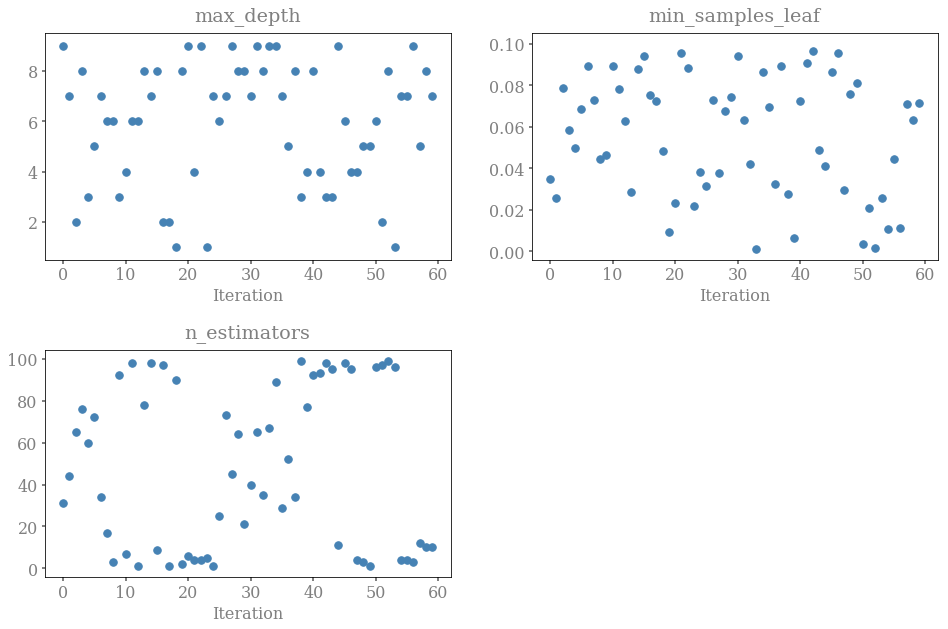

In [240]:
BOout.hyperparameter_convergence_plots()

### Example 2

In [255]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators': range(20,80),
    'max_depth': range(1,10),
#     'min_samples_leaf': [0.001,0.5]
}

# --- Run the Bayesian Optimisation Code
MLmodel = RandomForestRegressor(random_state=42)

def my_scoring_function(X_train, y_train):
    return np.mean(cross_val_score(MLmodel, X_train,y_train, cv=5))
#     return MLmodel.score(X_train, y_train)

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = MLmodel,
    scoring_function = my_scoring_function,
    NpI = 5,
    Niter = 55,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 100,
).optimise()

/Users/crookm12/Documents/GitHub/BayesianOptimisation/bayesian_hyperparameter_optimisation_3.py:537: UserWarning: Discrete hyperparameter detected: setting optim_rout to random_search
  warnings.warn('Discrete hyperparameter detected: setting optim_rout to random_search')
INFO:root:Performing initial 5 samples


{'max_depth': 3, 'n_estimators': 43} score: 0.8952644888419263
{'max_depth': 6, 'n_estimators': 79} score: 0.9654002511010098
{'max_depth': 5, 'n_estimators': 57} score: 0.9517981615070745
{'max_depth': 7, 'n_estimators': 23} score: 0.9711389918701576
{'max_depth': 6, 'n_estimators': 56} score: 0.9655799134914222


INFO:root:Will perform 55 iterations


Iteration: 0
{'max_depth': 8, 'n_estimators': 39} score: 0.9736843918573636
current accuracy: 0.9736843918573636
best accuracy: 0.9736843918573636
Iteration: 1
{'max_depth': 8, 'n_estimators': 79} score: 0.9739097337743073
current accuracy: 0.9739097337743073
best accuracy: 0.9739097337743073
Iteration: 2
{'max_depth': 6, 'n_estimators': 20} score: 0.9651595323355716
current accuracy: 0.9651595323355716
best accuracy: 0.9739097337743073
Iteration: 3
{'max_depth': 8, 'n_estimators': 79} score: 0.9739097337743073
current accuracy: 0.9739097337743073
best accuracy: 0.9739097337743073
Iteration: 4
{'max_depth': 9, 'n_estimators': 79} score: 0.9748750101060365
current accuracy: 0.9748750101060365
best accuracy: 0.9748750101060365
Iteration: 5
{'max_depth': 8, 'n_estimators': 20} score: 0.973630539486266
current accuracy: 0.973630539486266
best accuracy: 0.9748750101060365
Iteration: 6
{'max_depth': 3, 'n_estimators': 20} score: 0.8944789989354739
current accuracy: 0.8944789989354739
best ac

INFO:root:Best result 0.974878943965271: Params: {'max_depth': 9.0, 'n_estimators': 78.0}


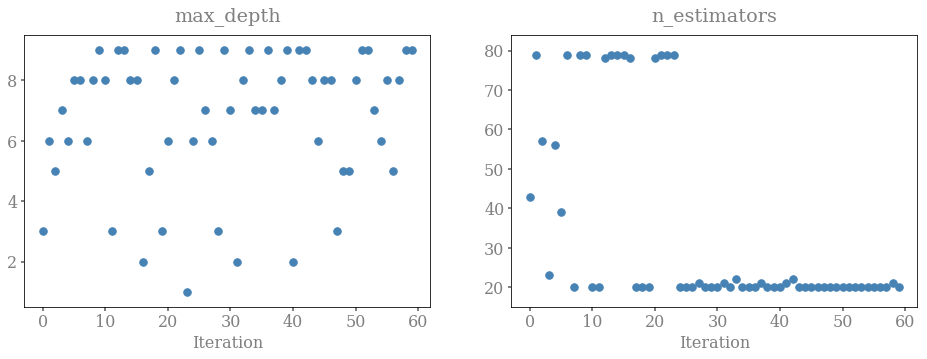

In [256]:
BOout.hyperparameter_convergence_plots()

## Convergence Diagnostics
Plot the convergence of the hyper parameters with each iteration

In [8]:
hps = {
    'n_estimators':range(1,20),
    'max_depth':range(1,10),
    'min_samples_leaf': [0.1,0.5]
}

# --- Run the Bayesian Optimisation Code
MLmodel = RandomForestRegressor(random_state=42)

noise = 0.05
BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = MLmodel,
    NpI = 5,
    Niter = 25,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 10
).optimise()

[autoreload of bayesian_hyperparameter_optimisation_3 failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/crookm12/Documents/GitHub/BayesianOpt

ndim: 1
{'max_depth': 3, 'min_samples_leaf': 0.30000000000000004, 'n_estimators': 13} score: 0.3336931732685191
{'max_depth': 1, 'min_samples_leaf': 0.38, 'n_estimators': 2} score: -0.004065434124759504
{'max_depth': 8, 'min_samples_leaf': 0.22000000000000003, 'n_estimators': 17} score: 0.46907179009709593
{'max_depth': 6, 'min_samples_leaf': 0.4600000000000001, 'n_estimators': 6} score: -0.003851707134288196


INFO:root:Will perform 25 iterations
INFO:root:Iteration 0


{'max_depth': 5, 'min_samples_leaf': 0.14, 'n_estimators': 10} score: 0.7835089048503446
optim rout: minimize
Ncontinous_hps: 1


AttributeError: 'iteration' object has no attribute 'discrete_values'

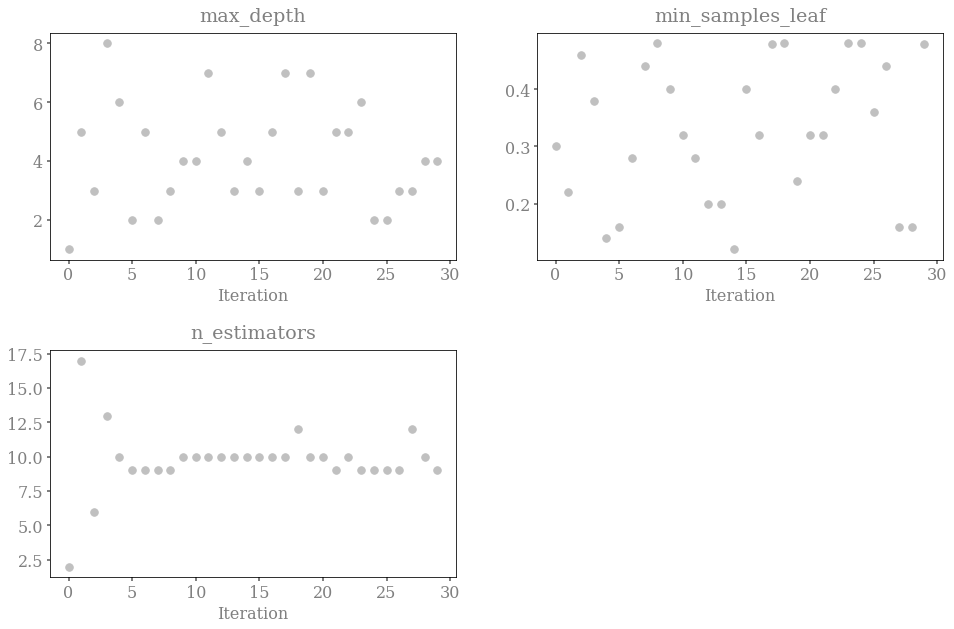

In [39]:
BOout.hyperparameter_convergence_plots()

# Try unsupervised learning

In [246]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

hps = {
    'n_clusters': range(1,20)
}

X_train, _ = make_blobs(n_samples=1000, centers=3, n_features=2)

# --- Run the Bayesian Optimisation Code
MLmodel = KMeans(random_state=42)

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = MLmodel,
    X_train = X_train
).optimise()

/Users/crookm12/Documents/GitHub/BayesianOptimisation/bayesian_hyperparameter_optimisation_3.py:537: UserWarning: Discrete hyperparameter detected: setting optim_rout to random_search
  optim_rout = 'random_search'
INFO:root:Performing initial 2 samples


{'n_clusters': 11} score: -159.8988749893558
{'n_clusters': 10} score: -175.21388644802855


INFO:root:Will perform 10 iterations


Iteration: 0
{'n_clusters': 10} score: -175.21388644802855
current accuracy: -175.21388644802855
best accuracy: -159.8988749893558
Iteration: 1
{'n_clusters': 19} score: -99.24592502372107
current accuracy: -99.24592502372107
best accuracy: -99.24592502372107
Iteration: 2
{'n_clusters': 1} score: -6454.457678708309
current accuracy: -6454.457678708309
best accuracy: -99.24592502372107
Iteration: 3
{'n_clusters': 16} score: -115.71466869522837
current accuracy: -115.71466869522837
best accuracy: -99.24592502372107
Iteration: 4
{'n_clusters': 19} score: -99.24592502372107
current accuracy: -99.24592502372107
best accuracy: -99.24592502372107
Iteration: 5
{'n_clusters': 19} score: -99.24592502372107
current accuracy: -99.24592502372107
best accuracy: -99.24592502372107
Iteration: 6
{'n_clusters': 2} score: -1020.7373205950413
current accuracy: -1020.7373205950413
best accuracy: -99.24592502372107
Iteration: 7
{'n_clusters': 7} score: -249.01870501811567
current accuracy: -249.018705018115

INFO:root:Best result -99.24592502372107: Params: {'n_clusters': 19.0}


# Using random_search solver for discrete valued hyperparameters

In [ ]:
training_size = 1000
X_train = 15*np.random.uniform(size=(1000,len(hps)))
# Generate noisy data from a 2D gaussian defined above
y_train = generate_noisy_data_from_bivariate_gaussian_nd(X_train, mu = [5, 10, 15], sig = [1, 5, 10])
y_train = y_train.ravel()

In [92]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators':range(1,20),
#     'max_depth':range(9,12),
    'min_samples_leaf': [0.0001, 0.5]
}

# --- Run the Bayesian Optimisation Code

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = RandomForestRegressor(random_state=42),
    NpI = 5,
    Niter = 90,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 30,
    optim_rout = 'random_search',
    noise = 0.01,
    xi = 0.01,
    kernel = RBF(length_scale=0.05)
)
BOout.optimise()

{'min_samples_leaf': 0.07547030834984308, 'n_estimators': 16} score: 0.5584880513390935
{'min_samples_leaf': 0.1313787595633155, 'n_estimators': 16} score: 0.3332925418439192
{'min_samples_leaf': 0.02377644683641375, 'n_estimators': 15} score: 0.8440103704569137
{'min_samples_leaf': 0.4674961529225334, 'n_estimators': 6} score: -0.0062162999713587744


INFO:root:Will perform 90 iterations
INFO:root:Iteration 0
INFO:root:Iteration 1


{'min_samples_leaf': 0.0935834539077896, 'n_estimators': 13} score: 0.5461443734942154
final res: [[0.42468673 8.        ]], [-0.39396223]
{'min_samples_leaf': 0.42468673276169594, 'n_estimators': 8} score: -0.006265855560931577
current accuracy: -0.006265855560931577
best accuracy: 0.8440103704569137


INFO:root:Iteration 2
INFO:root:Iteration 3


final res: [[1.e-04 2.e+00]], [-0.0935109]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 2} score: 0.9068410516028582
current accuracy: 0.9068410516028582
best accuracy: 0.9068410516028582
final res: [[0.5 1. ]], [-0.14565325]
{'min_samples_leaf': 0.5, 'n_estimators': 1} score: -0.008509636286777455
current accuracy: -0.008509636286777455
best accuracy: 0.9068410516028582


INFO:root:Iteration 4
INFO:root:Iteration 5


final res: [[1.e-04 3.e+00]], [-0.30963042]
{'min_samples_leaf': 0.0001, 'n_estimators': 3} score: 0.9167277650577057
current accuracy: 0.9167277650577057
best accuracy: 0.9167277650577057
final res: [[0.5 3. ]], [-0.03608805]
{'min_samples_leaf': 0.5, 'n_estimators': 3} score: -0.006129850999767372
current accuracy: -0.006129850999767372
best accuracy: 0.9167277650577057


INFO:root:Iteration 6


final res: [[ 0.5 14. ]], [-0.14731261]
{'min_samples_leaf': 0.5, 'n_estimators': 14} score: -0.007152899677226943
current accuracy: -0.007152899677226943
best accuracy: 0.9167277650577057
final res: [[1.0e-04 1.2e+01]], [-0.13727601]


INFO:root:Iteration 7
INFO:root:Iteration 8


{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.938221995813806
final res: [[ 0.5 11. ]], [-0.12702093]
{'min_samples_leaf': 0.5, 'n_estimators': 11} score: -0.006982438596177287
current accuracy: -0.006982438596177287
best accuracy: 0.938221995813806


INFO:root:Iteration 9


final res: [[1.0e-04 1.9e+01]], [-0.09289924]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668


INFO:root:Iteration 10


final res: [[1.0e-04 1.8e+01]], [-0.14198038]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 11


final res: [[ 0.5 19. ]], [-0.12599704]
{'min_samples_leaf': 0.5, 'n_estimators': 19} score: -0.007202174237086201
current accuracy: -0.007202174237086201
best accuracy: 0.9404985167895668


INFO:root:Iteration 12


final res: [[1.e-04 4.e+00]], [-0.09877247]
{'min_samples_leaf': 0.0001, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[ 0.5 12. ]], [-0.08280993]


INFO:root:Iteration 13
INFO:root:Iteration 14


{'min_samples_leaf': 0.5, 'n_estimators': 12} score: -0.0070094705166444
current accuracy: -0.0070094705166444
best accuracy: 0.9404985167895668
final res: [[1.e-04 5.e+00]], [-0.09660672]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668


INFO:root:Iteration 15


final res: [[1.e-04 1.e+01]], [-0.05355742]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 16


final res: [[1.e-04 9.e+00]], [-0.09243895]
{'min_samples_leaf': 0.0001, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668


INFO:root:Iteration 17


final res: [[0.5 9. ]], [-0.05007062]
{'min_samples_leaf': 0.5, 'n_estimators': 9} score: -0.0067357804885472385
current accuracy: -0.0067357804885472385
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.03461644]


INFO:root:Iteration 18
INFO:root:Iteration 19


{'min_samples_leaf': 0.0001, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.e-04 4.e+00]], [-0.03052824]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668


INFO:root:Iteration 20


final res: [[1.0e-04 1.8e+01]], [-0.02331839]
{'min_samples_leaf': 0.0001000000000000445, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 21


final res: [[1.e-04 1.e+01]], [-0.02918237]
{'min_samples_leaf': 0.0001, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 22


final res: [[1.0e-04 1.1e+01]], [-0.03534676]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668


INFO:root:Iteration 23


final res: [[1.0e-04 1.1e+01]], [-0.02344155]
{'min_samples_leaf': 0.0001, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668


INFO:root:Iteration 24


final res: [[1.e-04 1.e+01]], [-0.0216114]
{'min_samples_leaf': 0.0001, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 25


final res: [[1.e-04 4.e+00]], [-0.01943199]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.01793224]


INFO:root:Iteration 26


{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.01525775]


INFO:root:Iteration 27


{'min_samples_leaf': 0.0001, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.2e+01]], [-0.01470385]


INFO:root:Iteration 28


{'min_samples_leaf': 0.0001, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.01638285]


INFO:root:Iteration 29


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668
final res: [[1.e-04 4.e+00]], [-0.01412793]


INFO:root:Iteration 30


{'min_samples_leaf': 0.0001, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.1e+01]], [-0.01867754]


INFO:root:Iteration 31


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.9e+01]], [-0.01428589]


INFO:root:Iteration 32
INFO:root:Iteration 33


{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668
final res: [[1.e-04 2.e+00]], [-0.01380061]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 2} score: 0.9068410516028582
current accuracy: 0.9068410516028582
best accuracy: 0.9404985167895668


INFO:root:Iteration 34


final res: [[1.e-04 5.e+00]], [-0.01786915]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.01394015]


INFO:root:Iteration 35


{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.01228137]


INFO:root:Iteration 36


{'min_samples_leaf': 0.0001, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.1e+01]], [-0.01552368]


INFO:root:Iteration 37


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.e-04 9.e+00]], [-0.01337585]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668


INFO:root:Iteration 38
INFO:root:Iteration 39


final res: [[1.0e-04 1.2e+01]], [-0.01250772]
{'min_samples_leaf': 0.0001, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668


INFO:root:Iteration 40


final res: [[1.e-04 5.e+00]], [-0.01317915]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668


INFO:root:Iteration 41


final res: [[1.0e-04 1.1e+01]], [-0.01342077]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.01322106]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 42
INFO:root:Iteration 43


final res: [[1.0e-04 1.9e+01]], [-0.01272487]
{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668


INFO:root:Iteration 44


final res: [[1.0e-04 1.8e+01]], [-0.01172425]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 45


final res: [[1.0e-04 1.8e+01]], [-0.01056484]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 46


final res: [[1.e-04 4.e+00]], [-0.01093917]
{'min_samples_leaf': 0.0001, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[1.e-04 4.e+00]], [-0.00901733]


INFO:root:Iteration 47


{'min_samples_leaf': 0.0001, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.00963376]


INFO:root:Iteration 48


{'min_samples_leaf': 0.0001, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.e-04 9.e+00]], [-0.01145427]


INFO:root:Iteration 49


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.2e+01]], [-0.01063531]


INFO:root:Iteration 50


{'min_samples_leaf': 0.0001, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.9e+01]], [-0.01113549]


INFO:root:Iteration 51


{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.01067933]


INFO:root:Iteration 52


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668
final res: [[1.e-04 9.e+00]], [-0.01005781]


INFO:root:Iteration 53


{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668
final res: [[1.e-04 5.e+00]], [-0.01014542]
{'min_samples_leaf': 0.0001, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668


INFO:root:Iteration 54
INFO:root:Iteration 55


final res: [[1.0e-04 1.2e+01]], [-0.00951878]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668


INFO:root:Iteration 56


final res: [[1.0e-04 1.1e+01]], [-0.01142807]
{'min_samples_leaf': 0.0001, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668


INFO:root:Iteration 57


final res: [[1.0e-04 1.1e+01]], [-0.01028276]
{'min_samples_leaf': 0.0001, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.1e+01]], [-0.00936561]


INFO:root:Iteration 58


{'min_samples_leaf': 0.0001, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.00886543]


INFO:root:Iteration 59


{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.00960333]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 60
INFO:root:Iteration 61


final res: [[1.0e-04 1.2e+01]], [-0.00850724]
{'min_samples_leaf': 0.0001, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668


INFO:root:Iteration 62


final res: [[1.e-04 3.e+00]], [-0.00846399]
{'min_samples_leaf': 0.0001, 'n_estimators': 3} score: 0.9167277650577057
current accuracy: 0.9167277650577057
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.1e+01]], [-0.008632]


INFO:root:Iteration 63
INFO:root:Iteration 64


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.e-04 2.e+00]], [-0.00850273]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 2} score: 0.9068410516028582
current accuracy: 0.9068410516028582
best accuracy: 0.9404985167895668


INFO:root:Iteration 65


final res: [[1.e-04 1.e+01]], [-0.00872552]
{'min_samples_leaf': 0.0001, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 66


final res: [[1.e-04 1.e+01]], [-0.00805871]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 67


final res: [[1.e-04 9.e+00]], [-0.00890706]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668


INFO:root:Iteration 68


final res: [[1.0e-04 1.9e+01]], [-0.00995574]
{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668


INFO:root:Iteration 69


final res: [[1.0e-04 1.8e+01]], [-0.00821806]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 70


final res: [[1.e-04 5.e+00]], [-0.00807507]
{'min_samples_leaf': 0.0001, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.9e+01]], [-0.00906316]
{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668


INFO:root:Iteration 71


final res: [[1.0e-04 1.9e+01]], [-0.00836354]
{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668


INFO:root:Iteration 72
INFO:root:Iteration 73


final res: [[1.e-04 4.e+00]], [-0.0077194]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.9e+01]], [-0.00777608]


INFO:root:Iteration 74


{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.00766414]


INFO:root:Iteration 75


{'min_samples_leaf': 0.00010000000000001674, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.00741891]


INFO:root:Iteration 76


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.00718315]


INFO:root:Iteration 77


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.00676075]


INFO:root:Iteration 78


{'min_samples_leaf': 0.0001, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.e-04 9.e+00]], [-0.00791135]


INFO:root:Iteration 79


{'min_samples_leaf': 0.0001, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668
final res: [[1.e-04 9.e+00]], [-0.00720254]


INFO:root:Iteration 80


{'min_samples_leaf': 0.0001, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668
final res: [[1.e-04 5.e+00]], [-0.00682556]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668


INFO:root:Iteration 81
INFO:root:Iteration 82


final res: [[1.e-04 3.e+00]], [-0.00636478]
{'min_samples_leaf': 0.0001, 'n_estimators': 3} score: 0.9167277650577057
current accuracy: 0.9167277650577057
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.9e+01]], [-0.00717994]


INFO:root:Iteration 83


{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668
final res: [[1.e-04 4.e+00]], [-0.0066389]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668


INFO:root:Iteration 84
INFO:root:Iteration 85


final res: [[1.0e-04 1.8e+01]], [-0.0063861]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 86


final res: [[1.e-04 1.e+01]], [-0.00685151]
{'min_samples_leaf': 0.0001000000000000098, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 87


final res: [[1.e-04 9.e+00]], [-0.00659591]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668


INFO:root:Iteration 88


final res: [[1.0e-04 1.2e+01]], [-0.00752724]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668


INFO:root:Iteration 89


final res: [[1.0e-04 1.8e+01]], [-0.00605124]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Best result 0.9404985167895668: Params: [1.0e-04 1.9e+01]
INFO:root:Best result 0.9404985167895668: Params: {'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 19.0}


final res: [[1.e-04 4.e+00]], [-0.00574184]
{'min_samples_leaf': 0.00010000000000001674, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668


/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend.qt4', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'datapath', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'docstring.hardcopy', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core

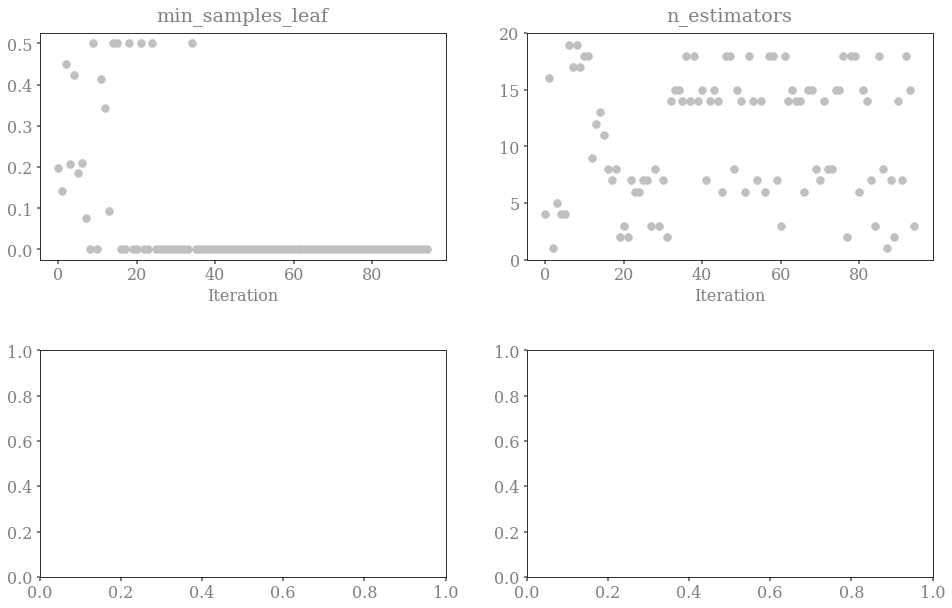

In [82]:
BOout.hyperparameter_convergence_plots()

/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend.qt4', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'datapath', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'docstring.hardcopy', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core

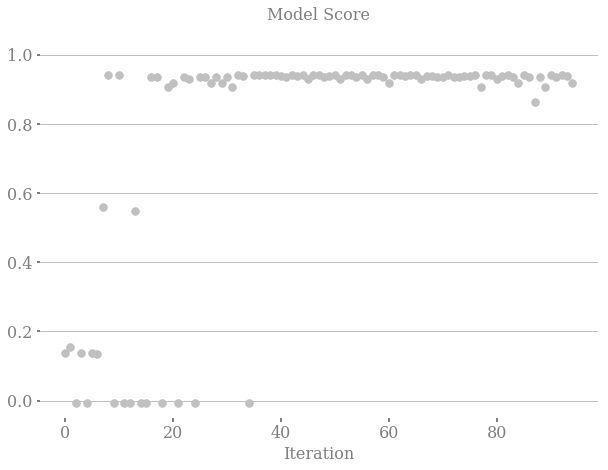

In [83]:
BOout.model_accuracy_convergence_plot()

In [95]:
BOout.best_params_vals

array([1.0e-04, 1.9e+01])

# Nested CV for Model Selection
When choosing the most performant model we need to choose the "best" or most tuned version of each model. For example, a well tuned SVM will probably out-perform a poorly tuned random forest. It is important to assess the performance of both the best SVM and the best random forest. It's also important to choose a model based on which can generalise best to new unseen data. Without such a step, we are simply using hyperparameter tuning to see which model can be tuned to best fit the training data. To overcome this we need nested cross validation. We need to split out training data into train/validation sets, perform tuning on the training set and then test the performance on the validation set. With nested CV we split our data into multiple training/validation sets and tune our parameters on each of the training sets, measure each optimised model on the validation set, and then average over all validation set scores. The output of this is a much less biased measure of the performance of either the SVM or random forest. Our most performant model can then be retuned to find the best version on all of the training data and this should be our chosen and optimal model.

To perform nested CV, we simply need to provide one additional parameter, nested_CV_folds, an integer that dictates how many outer folds we should use. Typical choices would be 5 or 10 as standard. All folds are equal sized (ignoring remainders). The default for this parameter is None in which case the hyperparameter tuning is performed on the whole of the provided training data. 

In [32]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound, upper_bound] for continuous
hps = {
#     'n_estimators': range(1, 20),
    'min_samples_leaf': range(1, 14),
    'min_samples_split': [0.001, 0.49]
}

# --- Run the Bayesian Optimisation Code
BOout = BayesianOptimisation(
    hps = hps,
    MLmodel = RandomForestRegressor(random_state=42, n_estimators = 10),
    y_train = y_train,
    X_train = X_train,
    nested_CV_folds = 10,
    optim_rout = 'grid_search',
    number_of_random_searches = 10
)
BOout.optimise()

INFO:root:Performing initial 4 samples



                {'min_samples_leaf': 7, 'min_samples_split': 0.45758982062698556}
                score: 0.5697029419524131

                {'min_samples_leaf': 4, 'min_samples_split': 0.3757439225417783}
                score: 0.746534494560686

                {'min_samples_leaf': 6, 'min_samples_split': 0.08446597404962165}
                score: 0.9273220642894421

                {'min_samples_leaf': 3, 'min_samples_split': 0.45921771467064093}
                score: 0.5697029419524131


INFO:root:Will perform 20 iterations
INFO:root:Performing initial 4 samples



                {'min_samples_leaf': 10, 'min_samples_split': 0.3873960128636703}
                score: 0.746534494560686

                {'min_samples_leaf': 9, 'min_samples_split': 0.4892080537155809}
                score: 0.5247540627736065

                {'min_samples_leaf': 12, 'min_samples_split': 0.015528421039226456}
                score: 0.9551052299781857

                {'min_samples_leaf': 13, 'min_samples_split': 0.28668869009747866}
                score: 0.7689114194017183

                Iteration: 0
[1] [-0.39396223]
[2] [-0.39396223]
[3] [-0.39396223]
[4] [-0.39396223]
[5] [-0.39396223]
[6] [-0.39396223]
[7] [-0.39396223]
[8] [-0.39396223]
[9] [-0.39396223]
[10] [-0.39396223]
[11] [-0.39396223]
[12] [-0.39396223]
[13] [-0.39396223]
[1] [-0.39396223]
[2] [-0.39396223]
[3] [-0.39396223]
[4] [-0.39396223]
[5] [-0.39396223]
[6] [-0.39396223]
[7] [-0.39396223]
[8] [-0.39396223]
[9] [-0.39396223]
[10] [-0.39396223]
[11] [-0.39396223]
[12] [-0.39396223]
[13] [-0.393

[6] [-0.39396223]
[7] [-0.39396223]
[8] [-0.39396223]
[9] [-0.39396223]
[10] [-0.39396223]
[11] [-0.39396223]
[12] [-0.39396223]
[13] [-0.39396223]
[1] [-0.39396223]
[2] [-0.39396223]
[3] [-0.39396223]
[4] [-0.39396223]
[5] [-0.39396223]
[6] [-0.39396223]
[7] [-0.39396223]
[8] [-0.39396223]
[9] [-0.39396223]
[10] [-0.39396223]
[11] [-0.39396223]
[12] [-0.39396223]
[13] [-0.39396223]
[1] [-0.39396223]
[2] [-0.39396223]
[3] [-0.39396223]
[4] [-0.39396223]
[5] [-0.39396223]
[6] [-0.39396223]
[7] [-0.39396223]
[8] [-0.39396223]
[9] [-0.39396223]
[10] [-0.39396223]
[11] [-0.39396223]
[12] [-0.39396223]
[13] [-0.39396223]
[1] [-0.39396223]
[2] [-0.39396223]
[3] [-0.39396223]
[4] [-0.39396223]
[5] [-0.39396223]
[6] [-0.39396223]
[7] [-0.39396223]
[8] [-0.39396223]
[9] [-0.39396223]
[10] [-0.39396223]
[11] [-0.39396223]
[12] [-0.39396223]
[13] [-0.39396223]
[1] [-0.39396223]
[2] [-0.39396223]
[3] [-0.39396223]
[4] [-0.39396223]
[5] [-0.39396223]
[6] [-0.39396223]
[7] [-0.39396223]
[8] [-0.3939

[6] [-0.00965225]
[7] [-0.00352057]
[8] [-0.00101338]
[9] [-0.0005502]
[10] [-0.00367314]
[11] [-0.02365322]
[12] [-0.02771292]
[13] [-0.01065515]
[1] [-0.00554017]
[2] [-0.01581311]
[3] [-0.0284353]
[4] [-0.02796987]
[5] [-0.01921175]
[6] [-0.00965225]
[7] [-0.00352057]
[8] [-0.00101338]
[9] [-1.18641025e-06]
[10] [-0.00367314]
[11] [-0.0132735]
[12] [-0.01924611]
[13] [-0.0062543]
[1] [-0.00554017]
[2] [-0.01581311]
[3] [-0.0284353]
[4] [-0.02796987]
[5] [-0.01921175]
[6] [-0.00965225]
[7] [-0.00352057]
[8] [-0.00101338]
[9] [-0.0005502]
[10] [-0.00367314]
[11] [-0.02365322]
[12] [-0.02771292]
[13] [-0.01065515]
[1] [-0.00554017]
[2] [-0.01581311]
[3] [-0.0284353]
[4] [-0.02796987]
[5] [-0.01921175]
[6] [-0.00965225]
[7] [-0.00352057]
[8] [-0.00101338]
[9] [-0.0005502]
[10] [-0.00367314]
[11] [-0.02365322]
[12] [-0.01924611]
[13] [-0.0062543]
[1] [-0.00554017]
[2] [-0.01581311]
[3] [-0.0284353]
[4] [-0.02796987]
[5] [-0.01921175]
[6] [-0.00965225]
[7] [-0.00352057]
[8] [-0.00101338]


[8] [-0.00116162]
[9] [-0.00047801]
[10] [-0.00168041]
[11] [-0.01167128]
[12] [-0.01395299]
[13] [-0.00482734]
[1] [-0.00515145]
[2] [-0.01779891]
[3] [-0.03406274]
[4] [-0.03239717]
[5] [-0.0219827]
[6] [-0.0111709]
[7] [-0.0041256]
[8] [-0.00116162]
[9] [-0.00047801]
[10] [-0.00168041]
[11] [-0.01167128]
[12] [-0.01395299]
[13] [-0.00482734]
[1] [-0.00055729]
[2] [-0.01574994]
[3] [-0.04214446]
[4] [-0.03805189]
[5] [-0.02116295]
[6] [-0.0111709]
[7] [-0.0041256]
[8] [-0.00116162]
[9] [-7.63797402e-08]
[10] [-2.04111055e-05]
[11] [-0.00559302]
[12] [-0.01025789]
[13] [-0.00252763]
[1] [-0.00055729]
[2] [-0.01574994]
[3] [-0.04214446]
[4] [-0.03805189]
[5] [-0.02116295]
[6] [-0.00764702]
[7] [-0.0041256]
[8] [-0.00116162]
[9] [-4.49112417e-08]
[10] [-2.04111055e-05]
[11] [-0.00559302]
[12] [-0.01025789]
[13] [-0.00252763]
[1] [-0.00515145]
[2] [-0.01574994]
[3] [-0.04214446]
[4] [-0.03805189]
[5] [-0.02116295]
[6] [-0.0111709]
[7] [-0.0041256]
[8] [-0.00116162]
[9] [-8.07354288e-07]


[13] [-0.00252763]
[1] [-0.00515145]
[2] [-0.01574994]
[3] [-0.04214446]
[4] [-0.03805189]
[5] [-0.02116295]
[6] [-0.0111709]
[7] [-0.0041256]
[8] [-0.00116162]
[9] [-0.00047801]
[10] [-0.00168041]
[11] [-0.01167128]
[12] [-0.01025789]
[13] [-0.00482734]
[1] [-0.00515145]
[2] [-0.01574994]
[3] [-0.04214446]
[4] [-0.03805189]
[5] [-0.02116295]
[6] [-0.0111709]
[7] [-0.0041256]
[8] [-0.00116162]
[9] [-1.28770132e-06]
[10] [-0.00168041]
[11] [-0.01167128]
[12] [-0.01025789]
[13] [-0.00252763]
[1] [-0.00515145]
[2] [-0.01779891]
[3] [-0.04214446]
[4] [-0.03805189]
[5] [-0.0219827]
[6] [-0.0111709]
[7] [-0.0041256]
[8] [-0.00116162]
[9] [-0.00047801]
[10] [-0.00168041]
[11] [-0.01167128]
[12] [-0.01395299]
[13] [-0.00482734]
[1] [-0.00515145]
[2] [-0.01779891]
[3] [-0.04214446]
[4] [-0.03805189]
[5] [-0.0219827]
[6] [-0.0111709]
[7] [-0.0041256]
[8] [-0.00116162]
[9] [-0.00047801]
[10] [-0.00168041]
[11] [-0.01167128]
[12] [-0.01395299]
[13] [-0.00482734]
[1] [-0.00055729]
[2] [-0.01574994]

[11] [-0.03158785]
[12] [-0.02916489]
[13] [-0.0075154]
[1] [-0.03793822]
[2] [-0.03290726]
[3] [-1.9089246e-06]
[4] [-0.00515051]
[5] [-0.00733342]
[6] [-0.0066985]
[7] [-0.0041177]
[8] [-0.00202074]
[9] [-2.87120733e-07]
[10] [-0.00020843]
[11] [-0.01728224]
[12] [-0.02253675]
[13] [-0.00434038]
[1] [-0.03793822]
[2] [-0.03290726]
[3] [-0.00743261]
[4] [-0.00515051]
[5] [-0.00733342]
[6] [-0.0066985]
[7] [-0.0041177]
[8] [-0.00202074]
[9] [-1.60019669e-06]
[10] [-0.00717792]
[11] [-0.03158785]
[12] [-0.02253675]
[13] [-0.00434038]
[1] [-0.03793822]
[2] [-0.03290726]
[3] [-0.00743261]
[4] [-0.00515051]
[5] [-0.00733342]
[6] [-0.0066985]
[7] [-0.0041177]
[8] [-0.00202074]
[9] [-0.00161834]
[10] [-0.00717792]
[11] [-0.03158785]
[12] [-0.02916489]
[13] [-0.0075154]
[1] [-0.03793822]
[2] [-0.03290726]
[3] [-0.00743261]
[4] [-0.00515051]
[5] [-0.00733342]
[6] [-0.0066985]
[7] [-0.0041177]
[8] [-0.00202074]
[9] [-0.00161834]
[10] [-0.00717792]
[11] [-0.03158785]
[12] [-0.02916489]
[13] [-0.

[4] [-0.0032103]
[5] [-0.00496297]
[6] [-0.00475865]
[7] [-0.00293177]
[8] [-0.00136859]
[9] [-0.00100427]
[10] [-0.00456173]
[11] [-0.02232064]
[12] [-0.01912066]
[13] [-0.00453869]
[1] [-0.02711258]
[2] [-0.0261315]
[3] [-0.00472484]
[4] [-0.0032103]
[5] [-0.00496297]
[6] [-0.00475865]
[7] [-0.00293177]
[8] [-0.00136859]
[9] [-0.00100427]
[10] [-0.00456173]
[11] [-0.02232064]
[12] [-0.01612372]
[13] [-0.00453869]
[1] [-0.02711258]
[2] [-0.0261315]
[3] [-1.37879212e-07]
[4] [-0.0032103]
[5] [-0.00496297]
[6] [-0.00475865]
[7] [-0.00293177]
[8] [-0.00136859]
[9] [-2.01923039e-08]
[10] [-8.67957013e-05]
[11] [-0.01227988]
[12] [-0.01612372]
[13] [-0.00261533]
[1] [-0.02711258]
[2] [-0.0261315]
[3] [-0.00472484]
[4] [-0.0032103]
[5] [-0.00496297]
[6] [-0.00475865]
[7] [-0.00293177]
[8] [-0.00136859]
[9] [-0.00100427]
[10] [-0.00456173]
[11] [-0.02232064]
[12] [-0.01912066]
[13] [-0.00453869]
[1] [-0.02711258]
[2] [-0.0261315]
[3] [-2.99777804e-07]
[4] [-0.0032103]
[5] [-0.00496297]
[6] [

[3] [-0.00472484]
[4] [-0.0032103]
[5] [-0.00496297]
[6] [-0.00475865]
[7] [-0.00293177]
[8] [-0.00136859]
[9] [-0.00100427]
[10] [-0.00456173]
[11] [-0.02232064]
[12] [-0.01912066]
[13] [-0.00453869]
[1] [-0.02711258]
[2] [-0.0261315]
[3] [-0.00472484]
[4] [-0.0032103]
[5] [-0.00496297]
[6] [-0.00475865]
[7] [-0.00293177]
[8] [-0.00136859]
[9] [-0.00100427]
[10] [-0.00456173]
[11] [-0.02232064]
[12] [-0.01912066]
[13] [-0.00453869]
[1] [-0.02711258]
[2] [-0.0261315]
[3] [-0.00472484]
[4] [-0.0032103]
[5] [-0.00496297]
[6] [-0.00475865]
[7] [-0.00293177]
[8] [-0.00136859]
[9] [-0.00100427]
[10] [-0.00456173]
[11] [-0.02232064]
[12] [-0.01612372]
[13] [-0.00261533]
[1] [-0.02711258]
[2] [-0.0261315]
[3] [-1.87992186e-07]
[4] [-0.0032103]
[5] [-0.00496297]
[6] [-0.00475865]
[7] [-0.00293177]
[8] [-0.00136859]
[9] [-3.89473761e-08]
[10] [-8.67957013e-05]
[11] [-0.01227988]
[12] [-0.01612372]
[13] [-0.00261533]
[1] [-0.02711258]
[2] [-0.0261315]
[3] [-0.00472484]
[4] [-0.0032103]
[5] [-0.0

[9] [-0.00082485]
[10] [-0.00374339]
[11] [-0.01911013]
[12] [-0.01394802]
[13] [-0.00208785]
[1] [-0.020223]
[2] [-0.02228778]
[3] [-0.00374212]
[4] [-0.00269212]
[5] [-0.00439385]
[6] [-0.0042899]
[7] [-0.00262423]
[8] [-0.00118472]
[9] [-0.00082485]
[10] [-0.00374339]
[11] [-0.01911013]
[12] [-0.01576653]
[13] [-0.00362158]
[1] [-0.020223]
[2] [-0.02228778]
[3] [-0.00374212]
[4] [-0.00269212]
[5] [-0.00439385]
[6] [-0.0042899]
[7] [-0.00262423]
[8] [-0.00118472]
[9] [-0.00082485]
[10] [-0.00374339]
[11] [-0.01911013]
[12] [-0.01576653]
[13] [-0.00362158]
[1] [-0.020223]
[2] [-0.02228778]
[3] [-0.00374212]
[4] [-0.00269212]
[5] [-0.00439385]
[6] [-0.0042899]
[7] [-0.00262423]
[8] [-0.00118472]
[9] [-0.00082485]
[10] [-0.00374339]
[11] [-0.01911013]
[12] [-0.01576653]
[13] [-0.00362158]
[1] [-0.020223]
[2] [-0.02228778]
[3] [-0.00374212]
[4] [-0.00269212]
[5] [-0.00439385]
[6] [-0.0042899]
[7] [-0.00262423]
[8] [-0.00118472]
[9] [-0.00082485]
[10] [-0.00374339]
[11] [-0.01911013]
[12]

[4] [-0.00490595]
[5] [-0.00380738]
[6] [-0.00304523]
[7] [-0.00255346]
[8] [-0.00226532]
[9] [-0.00212516]
[10] [-0.00209175]
[11] [-0.00213638]
[12] [-0.00223943]
[13] [-0.00238732]
[1] [-0.01053375]
[2] [-0.00827084]
[3] [-0.00638864]
[4] [-0.00490595]
[5] [-0.00380738]
[6] [-0.00304523]
[7] [-0.00255346]
[8] [-0.00226532]
[9] [-0.00212516]
[10] [-0.00209175]
[11] [-0.00213638]
[12] [-0.00223943]
[13] [-0.00238732]
[1] [-0.01053375]
[2] [-0.00827084]
[3] [-0.00638864]
[4] [-0.00490595]
[5] [-0.00380738]
[6] [-0.00304523]
[7] [-0.00255346]
[8] [-0.00226532]
[9] [-0.00212516]
[10] [-0.00209175]
[11] [-0.00213638]
[12] [-0.00223943]
[13] [-0.00238732]
[1] [-0.01053375]
[2] [-0.00827084]
[3] [-0.00638864]
[4] [-0.00490595]
[5] [-0.00380738]
[6] [-0.00304523]
[7] [-0.00255346]
[8] [-0.00226532]
[9] [-0.00212516]
[10] [-0.00209175]
[11] [-0.00213638]
[12] [-0.00223943]
[13] [-0.00238732]
[1] [-0.01053375]
[2] [-0.00827084]
[3] [-0.00638864]
[4] [-0.00490595]
[5] [-0.00380738]
[6] [-0.0030

[7] [-0.00255346]
[8] [-0.00226532]
[9] [-0.00212516]
[10] [-0.00209175]
[11] [-0.00213638]
[12] [-0.00223943]
[13] [-0.00238732]
[1] [-0.01053375]
[2] [-0.00827084]
[3] [-0.00638864]
[4] [-0.00490595]
[5] [-0.00380738]
[6] [-0.00304523]
[7] [-0.00255346]
[8] [-0.00226532]
[9] [-0.00212516]
[10] [-0.00209175]
[11] [-0.00213638]
[12] [-0.00223943]
[13] [-0.00238732]
[1] [-0.01053375]
[2] [-0.00827084]
[3] [-0.00638864]
[4] [-0.00490595]
[5] [-0.00380738]
[6] [-0.00304523]
[7] [-0.00255346]
[8] [-0.00226532]
[9] [-0.00212516]
[10] [-0.00209175]
[11] [-0.00213638]
[12] [-0.00223943]
[13] [-0.00238732]
[1] [-0.01053375]
[2] [-0.00827084]
[3] [-0.00638864]
[4] [-0.00490595]
[5] [-0.00380738]
[6] [-0.00304523]
[7] [-0.00255346]
[8] [-0.00226532]
[9] [-0.00212516]
[10] [-0.00209175]
[11] [-0.00213638]
[12] [-0.00223943]
[13] [-0.00238732]
[1] [-0.01053375]
[2] [-0.00827084]
[3] [-0.00638864]
[4] [-0.00490595]
[5] [-0.00380738]
[6] [-0.00304523]
[7] [-0.00255346]
[8] [-0.00226532]
[9] [-0.0021

[1] [-0.01574211]
[2] [-0.0158532]
[3] [-7.58598494e-08]
[4] [-0.00197492]
[5] [-0.00281782]
[6] [-0.00266315]
[7] [-0.00169156]
[8] [-0.00084124]
[9] [-4.07768856e-08]
[10] [-2.34453721e-05]
[11] [-0.00832358]
[12] [-0.01137851]
[13] [-0.00177366]
[1] [-0.01574211]
[2] [-0.0158532]
[3] [-1.10378573e-07]
[4] [-0.00197492]
[5] [-0.00281782]
[6] [-0.00266315]
[7] [-0.00169156]
[8] [-0.00084124]
[9] [-8.2685893e-08]
[10] [-0.00309449]
[11] [-0.00832358]
[12] [-0.01137851]
[13] [-0.00177366]
[1] [-0.01574211]
[2] [-6.96634897e-06]
[3] [-3.46396234e-08]
[4] [-3.19088414e-06]
[5] [-0.00281782]
[6] [-0.00266315]
[7] [-0.00169156]
[8] [-4.40417006e-06]
[9] [-6.90334795e-09]
[10] [-3.52693788e-05]
[11] [-0.00832358]
[12] [-0.01137851]
[13] [-0.00177366]
[1] [-0.01574211]
[2] [-0.0158532]
[3] [-6.60679687e-08]
[4] [-0.00197492]
[5] [-0.00281782]
[6] [-0.00266315]
[7] [-0.00169156]
[8] [-0.00084124]
[9] [-3.07610292e-08]
[10] [-2.33827433e-05]
[11] [-0.00832358]
[12] [-0.01137851]
[13] [-0.001773

[4] [-0.00550859]
[5] [-0.00484073]
[6] [-0.00433299]
[7] [-0.0039705]
[8] [-0.00373501]
[9] [-0.00360757]
[10] [-0.00357039]
[11] [-0.00360794]
[12] [-0.00370716]
[13] [-0.00385738]
[1] [-0.00852509]
[2] [-0.00735303]
[3] [-0.00634553]
[4] [-0.00550859]
[5] [-0.00484073]
[6] [-0.00433299]
[7] [-0.0039705]
[8] [-0.00373501]
[9] [-0.00360757]
[10] [-0.00357039]
[11] [-0.00360794]
[12] [-0.00370716]
[13] [-0.00385738]
[1] [-0.00852509]
[2] [-0.00735303]
[3] [-0.00634553]
[4] [-0.00550859]
[5] [-0.00484073]
[6] [-0.00433299]
[7] [-0.0039705]
[8] [-0.00373501]
[9] [-0.00360757]
[10] [-0.00357039]
[11] [-0.00360794]
[12] [-0.00370716]
[13] [-0.00385738]
[1] [-0.00852509]
[2] [-0.00735303]
[3] [-0.00634553]
[4] [-0.00550859]
[5] [-0.00484073]
[6] [-0.00433299]
[7] [-0.0039705]
[8] [-0.00373501]
[9] [-0.00360757]
[10] [-0.00357039]
[11] [-0.00360794]
[12] [-0.00370716]
[13] [-0.00385738]
[1] [-0.00852509]
[2] [-0.00735303]
[3] [-0.00634553]
[4] [-0.00550859]
[5] [-0.00484073]
[6] [-0.00433299

[2] [-0.00735303]
[3] [-0.00634553]
[4] [-0.00550859]
[5] [-0.00484073]
[6] [-0.00433299]
[7] [-0.0039705]
[8] [-0.00373501]
[9] [-0.00360757]
[10] [-0.00357039]
[11] [-0.00360794]
[12] [-0.00370716]
[13] [-0.00385738]
[1] [-0.00852509]
[2] [-0.00735303]
[3] [-0.00634553]
[4] [-0.00550859]
[5] [-0.00484073]
[6] [-0.00433299]
[7] [-0.0039705]
[8] [-0.00373501]
[9] [-0.00360757]
[10] [-0.00357039]
[11] [-0.00360794]
[12] [-0.00370716]
[13] [-0.00385738]
[1] [-0.00852509]
[2] [-0.00735303]
[3] [-0.00634553]
[4] [-0.00550859]
[5] [-0.00484073]
[6] [-0.00433299]
[7] [-0.0039705]
[8] [-0.00373501]
[9] [-0.00360757]
[10] [-0.00357039]
[11] [-0.00360794]
[12] [-0.00370716]
[13] [-0.00385738]

                {'min_samples_leaf': 1, 'min_samples_split': 0.0010000000000000009}
                score: 0.9720442185179248

                current accuracy: 0.9720442185179248
                best accuracy: 0.9724351052883714

                Iteration: 9
[1] [-0.01356428]
[2] [-0.01542006]
[3] [-0.00

[8] [-0.00083888]
[9] [-6.96036727e-08]
[10] [-9.23724178e-06]
[11] [-0.0085307]
[12] [-0.01160615]
[13] [-0.00133118]
[1] [-0.01356428]
[2] [-6.19892083e-06]
[3] [-2.42755542e-08]
[4] [-1.74947848e-06]
[5] [-0.00238715]
[6] [-0.00225744]
[7] [-0.00150521]
[8] [-2.19228285e-06]
[9] [-5.28635909e-09]
[10] [-2.74762598e-05]
[11] [-0.0085307]
[12] [-0.01160615]
[13] [-0.00133118]
[1] [-0.01356428]
[2] [-0.01542006]
[3] [-0.00229949]
[4] [-0.00171793]
[5] [-0.00238715]
[6] [-0.00225744]
[7] [-0.00150521]
[8] [-0.00083888]
[9] [-0.0006219]
[10] [-0.00181567]
[11] [-0.01258069]
[12] [-0.01199386]
[13] [-0.00309095]
[1] [-0.01356428]
[2] [-0.01542006]
[3] [-9.31883688e-08]
[4] [-0.00171793]
[5] [-0.00238715]
[6] [-0.00225744]
[7] [-0.00150521]
[8] [-0.00083888]
[9] [-9.11567054e-08]
[10] [-8.95316755e-06]
[11] [-0.0085307]
[12] [-0.01160615]
[13] [-0.00133118]
[1] [-0.01356428]
[2] [-0.01542006]
[3] [-0.00229949]
[4] [-0.00171793]
[5] [-0.00238715]
[6] [-0.00225744]
[7] [-0.00150521]
[8] [-0.

[3] [-0.00192809]
[4] [-0.00160159]
[5] [-0.00207763]
[6] [-0.00190989]
[7] [-0.0012878]
[8] [-0.00074769]
[9] [-0.00058254]
[10] [-0.00174688]
[11] [-0.01218561]
[12] [-0.01157967]
[13] [-0.00300943]
[1] [-0.01328848]
[2] [-5.09702137e-06]
[3] [-2.28653965e-08]
[4] [-1.6486178e-06]
[5] [-0.00207763]
[6] [-0.00190989]
[7] [-0.0012878]
[8] [-1.94738928e-06]
[9] [-6.14666106e-09]
[10] [-2.43509968e-05]
[11] [-0.00805278]
[12] [-0.01108943]
[13] [-0.00129612]
[1] [-0.01328848]
[2] [-0.01324698]
[3] [-6.99394249e-07]
[4] [-0.00160159]
[5] [-0.00207763]
[6] [-0.00190989]
[7] [-0.0012878]
[8] [-0.00074769]
[9] [-0.00058254]
[10] [-0.00174688]
[11] [-0.00805278]
[12] [-0.01108943]
[13] [-0.00300943]
[1] [-0.01328848]
[2] [-0.01324698]
[3] [-0.00192809]
[4] [-0.00160159]
[5] [-0.00207763]
[6] [-0.00190989]
[7] [-0.0012878]
[8] [-0.00074769]
[9] [-0.00058254]
[10] [-0.00174688]
[11] [-0.01218561]
[12] [-0.01108943]
[13] [-0.00300943]
[1] [-0.01328848]
[2] [-0.01324698]
[3] [-0.00192809]
[4] [-0

[10] [-0.00168981]
[11] [-0.01183332]
[12] [-0.01124131]
[13] [-0.00293589]
[1] [-0.01177385]
[2] [-0.01275918]
[3] [-0.00184766]
[4] [-0.00154978]
[5] [-0.00202917]
[6] [-0.00187341]
[7] [-0.00126531]
[8] [-0.00073386]
[9] [-0.00056822]
[10] [-0.00168981]
[11] [-0.01183332]
[12] [-0.01124131]
[13] [-0.00293589]
[1] [-0.01177385]
[2] [-0.01275918]
[3] [-0.00184766]
[4] [-0.00154978]
[5] [-0.00202917]
[6] [-0.00187341]
[7] [-0.00126531]
[8] [-0.00073386]
[9] [-0.00056822]
[10] [-0.00168981]
[11] [-0.01183332]
[12] [-0.01124131]
[13] [-0.00293589]
[1] [-0.01177385]
[2] [-0.01275918]
[3] [-0.00184766]
[4] [-0.00154978]
[5] [-0.00202917]
[6] [-0.00187341]
[7] [-0.00126531]
[8] [-0.00073386]
[9] [-0.00056822]
[10] [-0.00168981]
[11] [-0.01183332]
[12] [-0.01124131]
[13] [-0.00293589]
[1] [-0.01177385]
[2] [-0.01275918]
[3] [-1.2153114e-07]
[4] [-0.00154978]
[5] [-0.00202917]
[6] [-0.00187341]
[7] [-0.00126531]
[8] [-0.00073386]
[9] [-2.35620521e-07]
[10] [-7.45921134e-06]
[11] [-0.0078226]


[9] [-0.00056822]
[10] [-0.00168981]
[11] [-0.01183332]
[12] [-0.01124131]
[13] [-0.00293589]
[1] [-0.01177385]
[2] [-0.01275918]
[3] [-1.51139662e-07]
[4] [-0.00154978]
[5] [-0.00202917]
[6] [-0.00187341]
[7] [-0.00126531]
[8] [-0.00073386]
[9] [-3.21630596e-07]
[10] [-7.76991702e-06]
[11] [-0.0078226]
[12] [-0.01081866]
[13] [-0.00126055]
[1] [-0.01177385]
[2] [-0.01275918]
[3] [-0.00184766]
[4] [-0.00154978]
[5] [-0.00202917]
[6] [-0.00187341]
[7] [-0.00126531]
[8] [-0.00073386]
[9] [-0.00056822]
[10] [-0.00168981]
[11] [-0.01183332]
[12] [-0.01124131]
[13] [-0.00293589]
[1] [-2.89805075e-05]
[2] [-4.73816943e-06]
[3] [-1.95247597e-08]
[4] [-1.50027351e-06]
[5] [-0.00202917]
[6] [-0.00187341]
[7] [-0.00126531]
[8] [-1.84061675e-06]
[9] [-5.62790676e-09]
[10] [-2.27863216e-05]
[11] [-0.0078226]
[12] [-0.01081866]
[13] [-0.00126055]
[1] [-0.01177385]
[2] [-0.01275918]
[3] [-3.93157558e-08]
[4] [-0.00154978]
[5] [-0.00202917]
[6] [-0.00187341]
[7] [-0.00126531]
[8] [-0.00073386]
[9] [-

[6] [-0.00170396]
[7] [-0.00115578]
[8] [-0.00068581]
[9] [-1.05779702e-06]
[10] [-0.00165503]
[11] [-0.00759042]
[12] [-0.01056491]
[13] [-0.00289036]
[1] [-0.01164266]
[2] [-0.01136167]
[3] [-3.70424254e-07]
[4] [-0.001497]
[5] [-0.00188259]
[6] [-0.00170396]
[7] [-0.00115578]
[8] [-0.00068581]
[9] [-1.27041506e-06]
[10] [-0.00165503]
[11] [-0.00759042]
[12] [-0.01056491]
[13] [-0.00289036]
[1] [-0.01164266]
[2] [-0.01136167]
[3] [-0.00163717]
[4] [-0.001497]
[5] [-0.00188259]
[6] [-0.00170396]
[7] [-0.00115578]
[8] [-0.00068581]
[9] [-0.00054695]
[10] [-0.00165503]
[11] [-0.01163609]
[12] [-0.01102953]
[13] [-0.00289036]
[1] [-0.01164266]
[2] [-0.01136167]
[3] [-0.00163717]
[4] [-0.001497]
[5] [-0.00188259]
[6] [-0.00170396]
[7] [-0.00115578]
[8] [-0.00068581]
[9] [-0.00054695]
[10] [-0.00165503]
[11] [-0.01163609]
[12] [-0.01056491]
[13] [-0.00289036]
[1] [-0.01164266]
[2] [-0.01136167]
[3] [-0.00163717]
[4] [-0.001497]
[5] [-0.00188259]
[6] [-0.00170396]
[7] [-0.00115578]
[8] [-0.

[11] [-0.00743064]
[12] [-0.01037947]
[13] [-0.00122021]
[1] [-0.01049903]
[2] [-5.49728863e-06]
[3] [-3.11451448e-08]
[4] [-0.00146182]
[5] [-0.0018506]
[6] [-0.00168]
[7] [-0.00114112]
[8] [-0.00067697]
[9] [-3.32892484e-08]
[10] [-7.20753165e-06]
[11] [-0.00743064]
[12] [-0.01037947]
[13] [-0.00122021]
[1] [-0.01049903]
[2] [-0.01104888]
[3] [-4.96314139e-07]
[4] [-0.00146182]
[5] [-0.0018506]
[6] [-0.00168]
[7] [-0.00114112]
[8] [-0.00067697]
[9] [-0.00053789]
[10] [-0.00161868]
[11] [-0.00743064]
[12] [-0.01037947]
[13] [-0.00284489]
[1] [-0.01049903]
[2] [-0.01104888]
[3] [-0.00158534]
[4] [-0.00146182]
[5] [-0.0018506]
[6] [-0.00168]
[7] [-0.00114112]
[8] [-0.00067697]
[9] [-0.00053789]
[10] [-0.00161868]
[11] [-0.01140758]
[12] [-0.01081372]
[13] [-0.00284489]
[1] [-2.51177567e-05]
[2] [-3.6963713e-06]
[3] [-1.48968921e-08]
[4] [-1.13052614e-06]
[5] [-0.0018506]
[6] [-0.00168]
[7] [-0.00114112]
[8] [-1.32382472e-06]
[9] [-4.29758327e-09]
[10] [-2.0397161e-05]
[11] [-0.00743064]

[5] [-0.0018506]
[6] [-0.00168]
[7] [-0.00114112]
[8] [-0.00067697]
[9] [-4.79687903e-08]
[10] [-6.80523076e-06]
[11] [-0.00743064]
[12] [-0.01037947]
[13] [-0.00122021]
[1] [-0.01049903]
[2] [-5.23387998e-06]
[3] [-2.8224301e-08]
[4] [-0.00146182]
[5] [-0.0018506]
[6] [-0.00168]
[7] [-0.00114112]
[8] [-0.00067697]
[9] [-2.66479797e-08]
[10] [-2.0397161e-05]
[11] [-0.00743064]
[12] [-0.01037947]
[13] [-0.00122021]
[1] [-2.57017162e-05]
[2] [-3.96880332e-06]
[3] [-1.67132177e-08]
[4] [-1.46967976e-06]
[5] [-0.0018506]
[6] [-0.00168]
[7] [-0.00114112]
[8] [-1.75107409e-06]
[9] [-6.41902561e-09]
[10] [-2.0397161e-05]
[11] [-0.00743064]
[12] [-0.01037947]
[13] [-0.00122021]
[1] [-0.01049903]
[2] [-5.16073727e-06]
[3] [-2.74429956e-08]
[4] [-3.10791618e-06]
[5] [-0.0018506]
[6] [-0.00168]
[7] [-0.00114112]
[8] [-0.00067697]
[9] [-2.49600123e-08]
[10] [-2.0397161e-05]
[11] [-0.00743064]
[12] [-0.01037947]
[13] [-0.00122021]
[1] [-0.01049903]
[2] [-0.01104888]
[3] [-0.00158534]
[4] [-0.001461

[2] [-3.84881965e-06]
[3] [-1.4813551e-08]
[4] [-1.09052746e-06]
[5] [-0.00178509]
[6] [-0.00161788]
[7] [-0.00111697]
[8] [-1.22913742e-06]
[9] [-4.86370946e-09]
[10] [-1.94486102e-05]
[11] [-0.00765973]
[12] [-0.01064701]
[13] [-0.00112221]
[1] [-0.01049975]
[2] [-0.01118073]
[3] [-0.00158178]
[4] [-0.00142664]
[5] [-0.00178509]
[6] [-0.00161788]
[7] [-0.00111697]
[8] [-0.00068782]
[9] [-0.00053508]
[10] [-0.00120657]
[11] [-0.00938789]
[12] [-0.01064701]
[13] [-0.00289129]
[1] [-0.01049975]
[2] [-0.01118073]
[3] [-5.2705686e-08]
[4] [-0.00142664]
[5] [-0.00178509]
[6] [-0.00161788]
[7] [-0.00111697]
[8] [-0.00068782]
[9] [-1.01190079e-07]
[10] [-3.91387332e-06]
[11] [-0.00765973]
[12] [-0.01064701]
[13] [-0.00112221]
[1] [-0.01049975]
[2] [-4.77414357e-06]
[3] [-2.17671533e-08]
[4] [-2.178527e-06]
[5] [-0.00178509]
[6] [-0.00161788]
[7] [-0.00111697]
[8] [-2.61361624e-06]
[9] [-1.56737875e-08]
[10] [-1.94486102e-05]
[11] [-0.00765973]
[12] [-0.01064701]
[13] [-0.00112221]
[1] [-0.01

[2] [-3.77247257e-06]
[3] [-1.642669e-08]
[4] [-1.55024899e-06]
[5] [-0.00170156]
[6] [-0.00152031]
[7] [-0.00105216]
[8] [-1.73930046e-06]
[9] [-9.22373245e-09]
[10] [-1.86875342e-05]
[11] [-0.00751745]
[12] [-0.01049271]
[13] [-0.00111262]
[1] [-0.01042764]
[2] [-0.01015006]
[3] [-0.00144282]
[4] [-0.00139652]
[5] [-0.00170156]
[6] [-0.00152031]
[7] [-0.00105216]
[8] [-0.00065772]
[9] [-0.00052143]
[10] [-0.00118964]
[11] [-0.00928432]
[12] [-0.01020212]
[13] [-0.00286388]
[1] [-2.4819966e-05]
[2] [-3.46182461e-06]
[3] [-1.38657851e-08]
[4] [-1.07183177e-06]
[5] [-0.00170156]
[6] [-0.00152031]
[7] [-0.00105216]
[8] [-1.15774116e-06]
[9] [-5.05776077e-09]
[10] [-1.86875342e-05]
[11] [-0.00751745]
[12] [-0.01049271]
[13] [-0.00111262]
[1] [-0.01042764]
[2] [-0.01015006]
[3] [-3.78290456e-07]
[4] [-0.00139652]
[5] [-0.00170156]
[6] [-0.00152031]
[7] [-0.00105216]
[8] [-0.00065772]
[9] [-0.00052143]
[10] [-0.00118964]
[11] [-0.00751745]
[12] [-0.01049271]
[13] [-0.00286388]
[1] [-0.01042

[1] [-0.01042764]
[2] [-0.01015006]
[3] [-8.2587525e-07]
[4] [-0.00139652]
[5] [-0.00170156]
[6] [-0.00152031]
[7] [-0.00105216]
[8] [-0.00065772]
[9] [-0.00052143]
[10] [-0.00118964]
[11] [-0.00751745]
[12] [-0.01049271]
[13] [-0.00286388]
[1] [-0.01042764]
[2] [-0.01015006]
[3] [-4.16684013e-07]
[4] [-0.00139652]
[5] [-0.00170156]
[6] [-0.00152031]
[7] [-0.00105216]
[8] [-0.00065772]
[9] [-0.00052143]
[10] [-0.00118964]
[11] [-0.00751745]
[12] [-0.01049271]
[13] [-0.00286388]
[1] [-0.01042764]
[2] [-0.01015006]
[3] [-0.00144282]
[4] [-0.00139652]
[5] [-0.00170156]
[6] [-0.00152031]
[7] [-0.00105216]
[8] [-0.00065772]
[9] [-0.00052143]
[10] [-0.00118964]
[11] [-0.00928432]
[12] [-0.01020212]
[13] [-0.00286388]
[1] [-2.43760214e-05]
[2] [-3.31700782e-06]
[3] [-1.28806651e-08]
[4] [-8.61450928e-07]
[5] [-0.00170156]
[6] [-0.00152031]
[7] [-0.00105216]
[8] [-9.03909224e-07]
[9] [-3.69487204e-09]
[10] [-1.86875342e-05]
[11] [-0.00751745]
[12] [-0.01049271]
[13] [-0.00111262]
[1] [-0.01042

[10] [-0.00847075]
[11] [-0.00797159]
[12] [-0.00451774]
[13] [-0.00704262]
[1] [-0.00999688]
[2] [-0.01226978]
[3] [-3.61954737e-08]
[4] [-0.00449677]
[5] [-0.00795108]
[6] [-0.00989556]
[7] [-0.00948687]
[8] [-0.00787264]
[9] [-1.26625763e-06]
[10] [-1.1696858e-07]
[11] [-2.70601734e-06]
[12] [-1.33942688e-07]
[13] [-0.00704262]
[1] [-0.00999688]
[2] [-0.01226978]
[3] [-2.46645215e-08]
[4] [-0.00449677]
[5] [-0.00795108]
[6] [-0.00989556]
[7] [-0.00948687]
[8] [-0.00787264]
[9] [-5.33567983e-07]
[10] [-7.12993138e-08]
[11] [-2.31738602e-06]
[12] [-1.13738643e-07]
[13] [-0.00704262]
[1] [-0.00999688]
[2] [-0.01226978]
[3] [-2.46683416e-08]
[4] [-0.00449677]
[5] [-0.00795108]
[6] [-0.00989556]
[7] [-0.00948687]
[8] [-0.00787264]
[9] [-5.33774736e-07]
[10] [-7.13130949e-08]
[11] [-2.31752353e-06]
[12] [-1.13745065e-07]
[13] [-0.00704262]
[1] [-0.00999688]
[2] [-0.01226978]
[3] [-0.00235613]
[4] [-0.00449677]
[5] [-0.00795108]
[6] [-0.00989556]
[7] [-0.00948687]
[8] [-0.00787264]
[9] [-0

[9] [-0.00702747]
[10] [-6.53616618e-07]
[11] [-0.00785031]
[12] [-3.01989156e-07]
[13] [-0.00684984]
[1] [-0.00997637]
[2] [-0.01094954]
[3] [-0.0022296]
[4] [-0.00434481]
[5] [-0.00754728]
[6] [-0.00939894]
[7] [-0.00911769]
[8] [-0.00768964]
[9] [-0.00702747]
[10] [-0.0082827]
[11] [-0.00785031]
[12] [-0.00442275]
[13] [-0.00684984]
[1] [-0.00997637]
[2] [-0.01094954]
[3] [-0.0022296]
[4] [-0.00434481]
[5] [-0.00754728]
[6] [-0.00939894]
[7] [-0.00911769]
[8] [-0.00768964]
[9] [-0.00702747]
[10] [-0.0082827]
[11] [-0.00785031]
[12] [-0.00442275]
[13] [-0.00684984]
[1] [-0.00997637]
[2] [-0.01094954]
[3] [-0.0022296]
[4] [-0.00434481]
[5] [-0.00754728]
[6] [-0.00939894]
[7] [-0.00911769]
[8] [-0.00768964]
[9] [-0.00702747]
[10] [-0.0082827]
[11] [-0.00785031]
[12] [-0.00442275]
[13] [-0.00684984]
[1] [-0.00997637]
[2] [-0.01094954]
[3] [-0.0022296]
[4] [-0.00434481]
[5] [-0.00754728]
[6] [-0.00939894]
[7] [-0.00911769]
[8] [-0.00768964]
[9] [-0.00702747]
[10] [-0.0082827]
[11] [-0.00

[3] [-0.0022296]
[4] [-0.00434481]
[5] [-0.00754728]
[6] [-0.00939894]
[7] [-0.00911769]
[8] [-0.00768964]
[9] [-0.00702747]
[10] [-0.0082827]
[11] [-0.00785031]
[12] [-0.00442275]
[13] [-0.00684984]
[1] [-0.00997637]
[2] [-0.01094954]
[3] [-0.0022296]
[4] [-0.00434481]
[5] [-0.00754728]
[6] [-0.00939894]
[7] [-0.00911769]
[8] [-0.00768964]
[9] [-0.00702747]
[10] [-0.0082827]
[11] [-0.00785031]
[12] [-0.00442275]
[13] [-0.00684984]
[1] [-2.67058425e-05]
[2] [-4.58107378e-06]
[3] [-1.1456242e-08]
[4] [-0.00434481]
[5] [-0.00754728]
[6] [-0.00939894]
[7] [-0.00911769]
[8] [-0.00768964]
[9] [-4.07756979e-08]
[10] [-2.96596452e-08]
[11] [-1.74064016e-06]
[12] [-1.02125589e-07]
[13] [-1.59514591e-06]
[1] [-0.00997637]
[2] [-0.01094954]
[3] [-2.46005594e-07]
[4] [-0.00434481]
[5] [-0.00754728]
[6] [-0.00939894]
[7] [-0.00911769]
[8] [-0.00768964]
[9] [-0.00702747]
[10] [-0.0082827]
[11] [-0.00785031]
[12] [-5.08373615e-07]
[13] [-0.00684984]
[1] [-0.00997637]
[2] [-0.01094954]
[3] [-0.002229

[8] [-0.00754793]
[9] [-1.87271719e-08]
[10] [-2.6092241e-08]
[11] [-1.641228e-06]
[12] [-1.07707795e-07]
[13] [-1.24218966e-06]
[1] [-0.00992972]
[2] [-0.00992204]
[3] [-0.00213352]
[4] [-0.00423964]
[5] [-0.00726791]
[6] [-0.00904897]
[7] [-0.008849]
[8] [-0.00754793]
[9] [-0.00693547]
[10] [-0.00814025]
[11] [-0.00774705]
[12] [-0.00434471]
[13] [-0.00670845]
[1] [-0.00992972]
[2] [-0.00992204]
[3] [-0.00213352]
[4] [-0.00423964]
[5] [-0.00726791]
[6] [-0.00904897]
[7] [-0.008849]
[8] [-0.00754793]
[9] [-0.00693547]
[10] [-0.00814025]
[11] [-0.00774705]
[12] [-0.00434471]
[13] [-0.00670845]
[1] [-0.00992972]
[2] [-5.45046967e-06]
[3] [-2.56651342e-08]
[4] [-0.00423964]
[5] [-0.00726791]
[6] [-0.00904897]
[7] [-0.008849]
[8] [-0.00754793]
[9] [-7.18068943e-07]
[10] [-7.28576183e-08]
[11] [-2.26392989e-06]
[12] [-1.19638587e-07]
[13] [-0.00670845]
[1] [-0.00992972]
[2] [-5.18105009e-06]
[3] [-2.20755939e-08]
[4] [-0.00423964]
[5] [-0.00726791]
[6] [-0.00904897]
[7] [-0.008849]
[8] [-0

[8] [-0.00752821]
[9] [-0.00691184]
[10] [-0.00808399]
[11] [-0.00771651]
[12] [-1.25712937e-06]
[13] [-0.0066529]
[1] [-0.00923402]
[2] [-0.00988931]
[3] [-0.00211636]
[4] [-0.00420805]
[5] [-0.00721533]
[6] [-0.00898997]
[7] [-0.00880731]
[8] [-0.00752821]
[9] [-0.00691184]
[10] [-0.00808399]
[11] [-0.00771651]
[12] [-0.00432346]
[13] [-0.0066529]
[1] [-0.00923402]
[2] [-0.00988931]
[3] [-0.00211636]
[4] [-0.00420805]
[5] [-0.00721533]
[6] [-0.00898997]
[7] [-0.00880731]
[8] [-0.00752821]
[9] [-0.00691184]
[10] [-0.00808399]
[11] [-0.00771651]
[12] [-0.00432346]
[13] [-0.0066529]
[1] [-0.00923402]
[2] [-5.3420709e-06]
[3] [-2.49368901e-08]
[4] [-0.00420805]
[5] [-0.00721533]
[6] [-0.00898997]
[7] [-0.00880731]
[8] [-0.00752821]
[9] [-7.32252554e-07]
[10] [-7.17242372e-08]
[11] [-2.24254401e-06]
[12] [-1.20665901e-07]
[13] [-0.0066529]
[1] [-0.00923402]
[2] [-0.00988931]
[3] [-0.00211636]
[4] [-0.00420805]
[5] [-0.00721533]
[6] [-0.00898997]
[7] [-0.00880731]
[8] [-0.00752821]
[9] [-0

[8] [-0.00752821]
[9] [-8.82436043e-07]
[10] [-8.01949075e-08]
[11] [-2.32209083e-06]
[12] [-1.25078489e-07]
[13] [-0.0066529]
[1] [-0.00923402]
[2] [-0.00988931]
[3] [-0.00211636]
[4] [-0.00420805]
[5] [-0.00721533]
[6] [-0.00898997]
[7] [-0.00880731]
[8] [-0.00752821]
[9] [-0.00691184]
[10] [-0.00808399]
[11] [-0.00771651]
[12] [-0.00432346]
[13] [-0.0066529]
[1] [-0.00923402]
[2] [-0.00988931]
[3] [-0.00211636]
[4] [-0.00420805]
[5] [-0.00721533]
[6] [-0.00898997]
[7] [-0.00880731]
[8] [-0.00752821]
[9] [-0.00691184]
[10] [-0.00808399]
[11] [-0.00771651]
[12] [-0.00432346]
[13] [-0.0066529]
[1] [-0.00923402]
[2] [-0.00988931]
[3] [-7.15777296e-08]
[4] [-0.00420805]
[5] [-0.00721533]
[6] [-0.00898997]
[7] [-0.00880731]
[8] [-0.00752821]
[9] [-0.00691184]
[10] [-3.19932959e-07]
[11] [-3.70639112e-06]
[12] [-2.18761156e-07]
[13] [-0.0066529]
[1] [-0.00923402]
[2] [-5.77363379e-06]
[3] [-3.14154337e-08]
[4] [-0.00420805]
[5] [-0.00721533]
[6] [-0.00898997]
[7] [-0.00880731]
[8] [-0.0075

INFO:root:Best result 0.9724351052883714: Params: {'min_samples_leaf': 3, 'min_samples_split': 0.0010000000000000009}
INFO:root:Performing initial 4 samples



Inner CV performed. Score on outer validation set: 0.9730448814497292

                {'min_samples_leaf': 9, 'min_samples_split': 0.3395528260400731}
                score: 0.7394873785141782

                {'min_samples_leaf': 5, 'min_samples_split': 0.3783450702507842}
                score: 0.7377753165023322

                {'min_samples_leaf': 13, 'min_samples_split': 0.016902890067018745}
                score: 0.955302751460103

                {'min_samples_leaf': 7, 'min_samples_split': 0.42224872878500047}
                score: 0.7244336756012763

                Iteration: 0
[1] [-0.11007425]
[2] [-0.11110926]
[3] [-0.03702218]
[4] [-0.01901045]
[5] [-0.01911958]
[6] [-0.02042842]
[7] [-0.02101168]
[8] [-0.02271585]
[9] [-0.03200587]
[10] [-0.05901536]
[11] [-0.07953752]
[12] [-0.05981739]
[13] [-0.04145514]
[1] [-0.11007425]
[2] [-0.11110926]
[3] [-0.03702218]
[4] [-0.01901045]
[5] [-0.01911958]
[6] [-0.02042842]
[7] [-0.02101168]
[8] [-0.02271585]
[9] [-0.03200587]


[12] [-0.05981739]
[13] [-0.04145514]
[1] [-0.11007425]
[2] [-0.11110926]
[3] [-0.03702218]
[4] [-0.01901045]
[5] [-0.01911958]
[6] [-0.02042842]
[7] [-0.02101168]
[8] [-0.02271585]
[9] [-0.03200587]
[10] [-0.05901536]
[11] [-0.07953752]
[12] [-0.05981739]
[13] [-0.04145514]
[1] [-0.11007425]
[2] [-0.11110926]
[3] [-0.03702218]
[4] [-0.01901045]
[5] [-0.01911958]
[6] [-0.02042842]
[7] [-0.02101168]
[8] [-0.02271585]
[9] [-0.03200587]
[10] [-0.05901536]
[11] [-0.07953752]
[12] [-0.05981739]
[13] [-0.04145514]
[1] [-0.11007425]
[2] [-0.11110926]
[3] [-0.03702218]
[4] [-0.01901045]
[5] [-0.01911958]
[6] [-0.02042842]
[7] [-0.02101168]
[8] [-0.02271585]
[9] [-0.03200587]
[10] [-0.05901536]
[11] [-0.07953752]
[12] [-0.05981739]
[13] [-0.04145514]
[1] [-0.11007425]
[2] [-0.11110926]
[3] [-0.03702218]
[4] [-0.01901045]
[5] [-0.01911958]
[6] [-0.02042842]
[7] [-0.02101168]
[8] [-0.02271585]
[9] [-0.03200587]
[10] [-0.05901536]
[11] [-0.07953752]
[12] [-0.05981739]
[13] [-0.04145514]
[1] [-0.11

[9] [-0.00032998]
[10] [-0.00082679]
[11] [-0.00284728]
[12] [-0.01087298]
[13] [-0.03280844]
[1] [-0.07078658]
[2] [-0.03132859]
[3] [-0.00882504]
[4] [-0.0018145]
[5] [-0.00046879]
[6] [-0.00021048]
[7] [-0.00016043]
[8] [-0.00018975]
[9] [-0.00032998]
[10] [-0.00082679]
[11] [-0.00284728]
[12] [-0.01087298]
[13] [-0.03280844]
[1] [-0.07078658]
[2] [-0.03132859]
[3] [-0.00882504]
[4] [-0.0018145]
[5] [-0.00046879]
[6] [-0.00021048]
[7] [-0.00016043]
[8] [-0.00018975]
[9] [-0.00032998]
[10] [-0.00082679]
[11] [-0.00284728]
[12] [-0.01087298]
[13] [-0.03280844]
[1] [-0.07078658]
[2] [-0.03132859]
[3] [-0.00882504]
[4] [-0.0018145]
[5] [-0.00046879]
[6] [-0.00021048]
[7] [-0.00016043]
[8] [-0.00018975]
[9] [-0.00032998]
[10] [-0.00082679]
[11] [-0.00284728]
[12] [-0.01087298]
[13] [-0.03280844]
[1] [-0.07078658]
[2] [-0.03132859]
[3] [-0.00882504]
[4] [-0.0018145]
[5] [-0.00046879]
[6] [-0.00021048]
[7] [-0.00016043]
[8] [-0.00018975]
[9] [-0.00032998]
[10] [-0.00082679]
[11] [-0.002847

[13] [-0.01175964]
[1] [-0.01175991]
[2] [-0.01175983]
[3] [-0.01175976]
[4] [-0.01175971]
[5] [-0.01175966]
[6] [-0.01175962]
[7] [-0.0117596]
[8] [-0.01175958]
[9] [-0.01175957]
[10] [-0.01175957]
[11] [-0.01175959]
[12] [-0.01175961]
[13] [-0.01175964]
[1] [-0.0117599]
[2] [-0.01175983]
[3] [-0.01175976]
[4] [-0.0117597]
[5] [-0.01175966]
[6] [-0.01175962]
[7] [-0.01175959]
[8] [-0.01175958]
[9] [-0.01175957]
[10] [-0.01175957]
[11] [-0.01175958]
[12] [-0.01175961]
[13] [-0.01175964]
[1] [-0.01175991]
[2] [-0.01175983]
[3] [-0.01175976]
[4] [-0.01175971]
[5] [-0.01175966]
[6] [-0.01175962]
[7] [-0.0117596]
[8] [-0.01175958]
[9] [-0.01175957]
[10] [-0.01175957]
[11] [-0.01175959]
[12] [-0.01175961]
[13] [-0.01175964]
[1] [-0.0117599]
[2] [-0.01175983]
[3] [-0.01175976]
[4] [-0.0117597]
[5] [-0.01175966]
[6] [-0.01175962]
[7] [-0.01175959]
[8] [-0.01175958]
[9] [-0.01175957]
[10] [-0.01175957]
[11] [-0.01175958]
[12] [-0.01175961]
[13] [-0.01175964]
[1] [-0.0117599]
[2] [-0.01175983]


[6] [-0.01175962]
[7] [-0.01175959]
[8] [-0.01175958]
[9] [-0.01175957]
[10] [-0.01175957]
[11] [-0.01175958]
[12] [-0.01175961]
[13] [-0.01175964]
[1] [-0.01175991]
[2] [-0.01175983]
[3] [-0.01175976]
[4] [-0.01175971]
[5] [-0.01175966]
[6] [-0.01175962]
[7] [-0.0117596]
[8] [-0.01175958]
[9] [-0.01175957]
[10] [-0.01175957]
[11] [-0.01175959]
[12] [-0.01175961]
[13] [-0.01175964]
[1] [-0.01175991]
[2] [-0.01175983]
[3] [-0.01175976]
[4] [-0.01175971]
[5] [-0.01175966]
[6] [-0.01175962]
[7] [-0.0117596]
[8] [-0.01175958]
[9] [-0.01175957]
[10] [-0.01175957]
[11] [-0.01175959]
[12] [-0.01175961]
[13] [-0.01175964]
[1] [-0.01175991]
[2] [-0.01175983]
[3] [-0.01175976]
[4] [-0.01175971]
[5] [-0.01175966]
[6] [-0.01175962]
[7] [-0.01175959]
[8] [-0.01175958]
[9] [-0.01175957]
[10] [-0.01175957]
[11] [-0.01175959]
[12] [-0.01175961]
[13] [-0.01175964]
[1] [-0.01175991]
[2] [-0.01175983]
[3] [-0.01175976]
[4] [-0.01175971]
[5] [-0.01175966]
[6] [-0.01175962]
[7] [-0.0117596]
[8] [-0.0117595

[11] [-0.00734771]
[12] [-0.00747902]
[13] [-0.00765936]
[1] [-0.01173668]
[2] [-0.01073293]
[3] [-0.00985691]
[4] [-0.00908916]
[5] [-0.00848114]
[6] [-0.00802771]
[7] [-0.00765527]
[8] [-0.00742327]
[9] [-0.00729879]
[10] [-0.0072707]
[11] [-0.00732778]
[12] [-0.00745933]
[13] [-0.00765551]
[1] [-0.01173668]
[2] [-0.01073293]
[3] [-0.00985691]
[4] [-0.00911364]
[5] [-0.00850465]
[6] [-0.00800769]
[7] [-0.00767713]
[8] [-0.00744448]
[9] [-0.00731947]
[10] [-0.00727306]
[11] [-0.00733013]
[12] [-0.00746168]
[13] [-0.00765787]
[1] [-0.01170233]
[2] [-0.01070015]
[3] [-0.00982566]
[4] [-0.00908384]
[5] [-0.00847616]
[6] [-0.00800036]
[7] [-0.00765076]
[8] [-0.00741889]
[9] [-0.00729448]
[10] [-0.0072664]
[11] [-0.00732345]
[12] [-0.00745493]
[13] [-0.00765102]
[1] [-0.01173668]
[2] [-0.01073293]
[3] [-0.00985691]
[4] [-0.00911364]
[5] [-0.00850465]
[6] [-0.00802771]
[7] [-0.00765672]
[8] [-0.00742468]
[9] [-0.00730018]
[10] [-0.00727207]
[11] [-0.00732914]
[12] [-0.00746069]
[13] [-0.007

[4] [-0.00515826]
[5] [-0.00395204]
[6] [-0.00317234]
[7] [-0.00271277]
[8] [-0.00247947]
[9] [-0.00240267]
[10] [-0.00243505]
[11] [-0.00254548]
[12] [-0.00271335]
[13] [-0.00292457]
[1] [-0.01199027]
[2] [-0.00916485]
[3] [-0.00688159]
[4] [-0.00515826]
[5] [-0.00395204]
[6] [-0.00317234]
[7] [-0.00271277]
[8] [-0.00247947]
[9] [-0.00240267]
[10] [-0.00243505]
[11] [-0.00254548]
[12] [-0.00271335]
[13] [-0.00292457]
[1] [-0.01199027]
[2] [-0.00916485]
[3] [-0.00688159]
[4] [-0.00515826]
[5] [-0.00389216]
[6] [-0.00312203]
[7] [-0.00266877]
[8] [-0.00243924]
[9] [-0.00236443]
[10] [-0.00239761]
[11] [-0.0025081]
[12] [-0.00267556]
[13] [-0.00292457]
[1] [-0.01199027]
[2] [-0.00916485]
[3] [-0.00688159]
[4] [-0.00515826]
[5] [-0.00395204]
[6] [-0.00317234]
[7] [-0.00271277]
[8] [-0.00247947]
[9] [-0.00240267]
[10] [-0.00243505]
[11] [-0.00254548]
[12] [-0.00271335]
[13] [-0.00292457]
[1] [-0.01199027]
[2] [-0.00916485]
[3] [-0.00688159]
[4] [-0.00515826]
[5] [-0.00395204]
[6] [-0.00317

[4] [-0.00515826]
[5] [-0.00395204]
[6] [-0.00317234]
[7] [-0.00271277]
[8] [-0.00247947]
[9] [-0.00240267]
[10] [-0.00243505]
[11] [-0.00254548]
[12] [-0.00271335]
[13] [-0.00292457]
[1] [-0.01199027]
[2] [-0.00916485]
[3] [-0.00688159]
[4] [-0.00515826]
[5] [-0.00395204]
[6] [-0.00317234]
[7] [-0.00271277]
[8] [-0.00247947]
[9] [-0.00240267]
[10] [-0.00243505]
[11] [-0.00254548]
[12] [-0.00271335]
[13] [-0.00292457]

                {'min_samples_leaf': 1, 'min_samples_split': 0.0010000000000000009}
                score: 0.9706667770127364

                current accuracy: 0.9706667770127364
                best accuracy: 0.971572375110416

                Iteration: 5
[1] [-0.0111629]
[2] [-0.00765836]
[3] [-0.0050398]
[4] [-0.00327765]
[5] [-0.00221001]
[6] [-0.00162002]
[7] [-0.00132268]
[8] [-0.00119679]
[9] [-0.00117329]
[10] [-0.00121451]
[11] [-0.0012994]
[12] [-0.00141543]
[13] [-0.00155463]
[1] [-0.0111629]
[2] [-0.00765836]
[3] [-0.0050398]
[4] [-0.00327765]
[5] [-0.00221

[2] [-0.00765836]
[3] [-0.0050398]
[4] [-0.00327765]
[5] [-0.00221001]
[6] [-0.00162002]
[7] [-0.00132268]
[8] [-0.00119679]
[9] [-0.00117329]
[10] [-0.00121451]
[11] [-0.0012994]
[12] [-0.00141543]
[13] [-0.00155463]
[1] [-0.0111629]
[2] [-0.00765836]
[3] [-0.0050398]
[4] [-0.00327765]
[5] [-0.00215648]
[6] [-0.00157846]
[7] [-0.00128788]
[8] [-0.00116544]
[9] [-0.00114344]
[10] [-0.001185]
[11] [-0.00126956]
[12] [-0.00138492]
[13] [-0.00155463]
[1] [-0.0111629]
[2] [-0.00765836]
[3] [-0.0050398]
[4] [-0.00327765]
[5] [-0.00221001]
[6] [-0.00162002]
[7] [-0.00132268]
[8] [-0.00119679]
[9] [-0.00117329]
[10] [-0.00121451]
[11] [-0.0012994]
[12] [-0.00141543]
[13] [-0.00155463]
[1] [-0.0111629]
[2] [-0.00765836]
[3] [-0.0050398]
[4] [-0.00327765]
[5] [-0.00221001]
[6] [-0.00162002]
[7] [-0.00132268]
[8] [-0.00119679]
[9] [-0.00117329]
[10] [-0.00121451]
[11] [-0.0012994]
[12] [-0.00141543]
[13] [-0.00155463]
[1] [-0.0111629]
[2] [-0.00765836]
[3] [-0.0050398]
[4] [-0.00327765]
[5] [-0.

[3] [-0.00383807]
[4] [-0.00217727]
[5] [-0.00134397]
[6] [-0.00093768]
[7] [-0.00075538]
[8] [-0.00068928]
[9] [-0.00068743]
[10] [-0.00072466]
[11] [-0.00078792]
[12] [-0.00086977]
[13] [-0.00096554]
[1] [-0.01027472]
[2] [-0.00647457]
[3] [-0.00383807]
[4] [-0.00224189]
[5] [-0.0013453]
[6] [-0.00093872]
[7] [-0.00075643]
[8] [-0.00069045]
[9] [-0.00068877]
[10] [-0.00072619]
[11] [-0.00078966]
[12] [-0.00087171]
[13] [-0.00099139]
[1] [-0.01027472]
[2] [-0.00647457]
[3] [-0.00383807]
[4] [-0.00224189]
[5] [-0.00138797]
[6] [-0.00097043]
[7] [-0.00078248]
[8] [-0.00071381]
[9] [-0.00071108]
[10] [-0.00074833]
[11] [-0.00081211]
[12] [-0.00089473]
[13] [-0.00099139]
[1] [-0.01027472]
[2] [-0.00647457]
[3] [-0.00383807]
[4] [-0.00224189]
[5] [-0.00138797]
[6] [-0.00097043]
[7] [-0.00078248]
[8] [-0.00071381]
[9] [-0.00071108]
[10] [-0.00074833]
[11] [-0.00081211]
[12] [-0.00089473]
[13] [-0.00099139]
[1] [-0.01027472]
[2] [-0.00647457]
[3] [-0.00383807]
[4] [-0.00224189]
[5] [-0.00138

[10] [-1.84213757e-05]
[11] [-0.00027966]
[12] [-0.0025747]
[13] [-0.01309263]
[1] [-0.01431123]
[2] [-0.00187293]
[3] [-7.21621913e-05]
[4] [-6.57833291e-05]
[5] [-5.29580943e-06]
[6] [-2.06398247e-06]
[7] [-1.21664899e-06]
[8] [-1.39462138e-06]
[9] [-3.67383972e-06]
[10] [-6.81763844e-05]
[11] [-0.00038987]
[12] [-0.00268254]
[13] [-0.01325563]
[1] [-0.01089295]
[2] [-0.00084794]
[3] [-0.00017176]
[4] [-6.57833291e-05]
[5] [-2.97211142e-05]
[6] [-1.55346214e-05]
[7] [-1.06616215e-05]
[8] [-1.12119398e-05]
[9] [-2.04041769e-05]
[10] [-6.81763844e-05]
[11] [-0.00038987]
[12] [-0.00268254]
[13] [-0.01325563]
[1] [-0.01089295]
[2] [-0.00084794]
[3] [-0.00017176]
[4] [-6.57833291e-05]
[5] [-2.97211142e-05]
[6] [-1.55346214e-05]
[7] [-3.80211168e-06]
[8] [-4.1313381e-06]
[9] [-2.04041769e-05]
[10] [-6.81763844e-05]
[11] [-0.00038987]
[12] [-0.00268254]
[13] [-0.01325563]
[1] [-0.01089295]
[2] [-0.00084794]
[3] [-0.00017176]
[4] [-6.57833291e-05]
[5] [-2.97211142e-05]
[6] [-1.55346214e-05]


KeyboardInterrupt: 

In [29]:
np.array([1, 4]).reshape(1, -1)[0]


array([1, 4])

In [11]:
mydict

{0: 'a', 1: 'b', 2: 'c'}

# Ignore this for now...

In [165]:
# X = np.zeros((ndim, len(hps)))
# X[:, 0] = np.random.choice(hps[sorted(hps)[0]], size = ndim)#BOout.best_params_vals[0]
# X[:, 1] = np.linspace(0.1, 0.5, ndim)
# X[:, 2] = np.random.choice(hps[sorted(hps)[2]], size = ndim)#BOout.best_params_vals[2]

noise = 0.001
# x=np.linspace(0.1, 0.5).reshape(-1,1)
y, std = BOout.gpr.predict(X, return_std=True)
y1, std1 = GaussianProcessRegressor(kernel=RBF(), alpha=0.1).fit(BOout.Xt[:, 1].reshape(-1, 1), BOout.Yt).predict(X[:,1].reshape(-1, 1), return_std=True)
plt.plot(X[:,1], y)
# plt.plot(X[:,1], y - std, '--')
# plt.plot(X[:,1], y + std, '--')
plt.plot(BOout.Xt[:,1], BOout.Yt, '.')
plt.plot(X[:,1], y1, '.')

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

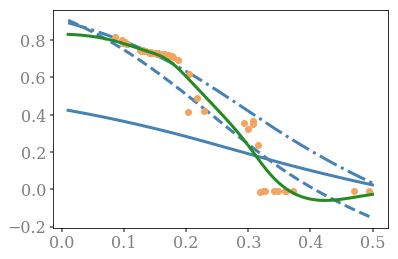

In [175]:
ndim = BOout.Xt.shape[0]

X = np.zeros((ndim, 4))
X[:, 0] = np.linspace(0.01, 0.5, ndim)
for i in range(1, 4):
    X[:, i] = i
    
plot_i = 1
y, std = BOout.gpr.predict(X[:, [0, plot_i]], return_std=True)
plot_i = 2
y_, std_ = BOout.gpr.predict(X[:, [0, plot_i]], return_std=True)
plot_i = 3
y__, std__ = BOout.gpr.predict(X[:, [0, plot_i]], return_std=True)

y1, std1 = GaussianProcessRegressor(kernel=Matern(), alpha=0.0125).fit(BOout.Xt[:, 0].reshape(-1, 1), BOout.Yt)\
    .predict(X[:,[0]], return_std=True)

plt.plot(X[:,0], y, color = 'steelblue', linewidth = 3)
plt.plot(X[:,0], y_, '--', color = 'steelblue', linewidth = 3)
plt.plot(X[:,0], y__, '-.', color = 'steelblue', linewidth = 3)
plt.plot(BOout.Xt[:,0], BOout.Yt, '.', color = 'sandybrown', markersize = 12)
plt.plot(X[:,0], y1, color = 'forestgreen', linewidth = 3)

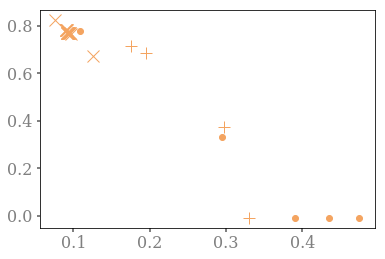

In [143]:
plt.plot(BOout.Xt[BOout.Xt[:, 1] == 1, 0], BOout.Yt[BOout.Xt[:, 1] == 1], 'x', color = 'sandybrown', markersize = 12)
plt.plot(BOout.Xt[BOout.Xt[:, 1] == 2, 0], BOout.Yt[BOout.Xt[:, 1] == 2], '.', color = 'sandybrown', markersize = 12)
plt.plot(BOout.Xt[BOout.Xt[:, 1] == 3, 0], BOout.Yt[BOout.Xt[:, 1] == 3], '+', color = 'sandybrown', markersize = 12)

In [26]:
noise = 0.001
# x=np.linspace(0.1, 0.5).reshape(-1,1)
y, std = BOout.gpr.predict(X, return_std=True)
y1, std1 = GaussianProcessRegressor(kernel=RBF(), alpha=0.1).fit(BOout.Xt[:, 1].reshape(-1, 1), BOout.Yt).predict(X[:,1].reshape(-1, 1), return_std=True)
plt.plot(X[:,1], y)
# plt.plot(X[:,1], y - std, '--')
# plt.plot(X[:,1], y + std, '--')
plt.plot(BOout.Xt[:,1], BOout.Yt, '.')
plt.plot(X[:,1], y1, '.')

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

In [146]:
y1


array([-1.83090872e-007,  9.33336254e-061,  3.23542516e-121,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        1.79261038e-119, -2.02127050e-301, -2.65832982e-301,
       -3.23918971e-242,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  4.76520317e-001,  0.00000000e+000,
        1.12019470e-295,  0.00000000e+000,  4.05230613e-060,
        6.15450612e-238,  0.00000000e+000, -2.00465774e-125,
        1.13053885e-059,  8.99325934e-120,  1.34607900e-059,
        0.00000000e+000, -1.08859087e-301,  6.85738453e-119,
        1.80735970e-237,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  6.00695818e-001,  0.00000000e+000,
        0.00000000e+000, -1.09054977e-298,  0.00000000e+000,
        0.00000000e+000,  1.08444270e-060,  1.98584291e-296,
       -4.03984531e-062,  0.00000000e+000,  0.00000000e+000,
       -9.88845497e-064,  0.00000000e+000, -2.94823117e-121,
        0.00000000e+000,